# Imports

In [ ]:
import os
import pandas as pd
import re
from bs4 import BeautifulSoup
import contractions
import nltk
from tabulate import tabulate
from textblob import TextBlob
import matplotlib.pyplot as plt
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from gensim.corpora.dictionary import Dictionary
import plotly.graph_objects as go
from collections import Counter
from wordcloud import WordCloud
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import plotly.graph_objects as go
import re


nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('omw-1.4')

pyLDAvis.enable_notebook()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/adam_ehrenberger/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/adam_ehrenberger/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/adam_ehrenberger/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/adam_ehrenberger/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/adam_ehrenberger/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Data Loading

## Loading data from Twitter (X)

In [ ]:
# Changing the current working directory
os.chdir('/Users/adam_ehrenberger/Documents/Dokumenty - Adam - MacBook Pro/Dokumenty/Škola/VŠE – Data Analytics/Bakalářská práce/Praktická část/data')


In [ ]:
# Loading CSV files and concatenating them into a single DataFrame
data_twitter = pd.concat([
    pd.read_csv('filtered_super_app_2.csv'),
    pd.read_csv('filtered_super_apps_tweets.csv')
], ignore_index=True)

# Adding a new column called 'source' with the value 'super_apps_twitter'
data_twitter['source'] = 'super_apps_twitter'

In [4]:
print(len(data_twitter))

32021


In [ ]:
# detecting the language of the tweets and filtering out non-English tweets
import langid
data_twitter["language_det"] = data_twitter["Tweet_Content"].apply(lambda x: langid.classify(x)[0] if isinstance(x, str) else "")
data_twitter = data_twitter[data_twitter["language_det"] == "en"]
print(len(data_twitter))

20051


In [ ]:
# Sometimes the superapp phrase is in the username, thats why we are filtering tweets that contain the phrase in the tweet content
# Defining the phrases to search for
phrases = ["super app", "superapp", "super-app", "super apps", "superapps", "super-apps"]

# Creating a regex pattern to match any of the phrases (case-insensitive)
pattern = '|'.join(map(re.escape, phrases))

# Filtering the dataset for tweets containing any of the phrases
data_twitter = data_twitter[data_twitter['Tweet_Content'].str.contains(pattern, case=False, na=False)]


In [ ]:
# Defining a function to categorize data based on conditions
def categorize(row):
    # Converting comments to lowercase for case-insensitive matching
    text = row['Tweet_Content'].lower()
    if 'wechat' in text:
        return 'wechat'
    elif 'kakaotalk' in text or 'kakao talk' in text or 'kakao-talk' in text:
        return 'kakaotalk'
    elif 'gojek' in text:
        return 'gojek'
    elif 'grab' in text:
        return 'grab'
    elif 'revolut' in text:
        return 'revolut'
    elif 'alipay' in text:
        return 'alipay'
    else:
        return 'other'  

# Applying the function to create the new 'category' column
data_twitter['category'] = data_twitter.apply(categorize, axis=1)

In [28]:
data_twitter.head()

,Query_Str,Post_URL,Author_Name,Author_Web_Page_URL,Author_Handle,Verified_Status,UTC_Time,Ads,Tweet_Content,Post_ID,...,Tweet_Image_URL,Replying_to,Reply_to_Whom,Reply_to_Whom_URL,Reply_to_Whom_Username,Reply_to_Whom_Handle,Language,source,language_det,category
0,"""""superapp""""","https://x.com/search?q=""""superapp"""" until:2020...",Iron Wil Becker,https://x.com/ir0nw1l,ir0nw1l,True,2020-01-01 20:00:49+00:00,False,your will power can be used to change your nat...,1.212464e+18,...,https://pbs.twimg.com/media/ENOJUUfWkAAXahA.jpg,False,NaN,NaN,NaN,NaN,en,super_apps_twitter,en,other
1,"""""superapp""""","https://x.com/search?q=""""superapp"""" until:2020...",Iron Wil Becker,https://x.com/ir0nw1l,ir0nw1l,True,2020-01-01 08:00:58+00:00,False,"as this year begins, what are you doing to mak...",1.212283e+18,...,https://pbs.twimg.com/media/ENLkjyDX0AE2W4O.jpg,False,NaN,NaN,NaN,NaN,en,super_apps_twitter,en,other
3,"""""superapp""""","https://x.com/search?q=""""superapp"""" until:2020...",Bajaj Markets,https://x.com/BajajMARKETS,BajajMARKETS,False,2020-01-01 11:32:31+00:00,False,Here's wishing everyone a very #HappyNewYear! ...,1.212336e+18,...,NaN,False,NaN,NaN,NaN,NaN,en,super_apps_twitter,en,other
7,"""""superapp""""","https://x.com/search?q=""""superapp"""" until:2020...",Halaldotmy,https://x.com/halaldotmy,halaldotmy,False,2020-01-01 06:45:53+00:00,False,#marketing #follow #deals #shop #onlinemarketi...,1.212264e+18,...,NaN,True,halaldotmy,https://x.com/halaldotmy,NaN,halaldotmy,qht,super_apps_twitter,en,other
8,"""""superapp""""","https://x.com/search?q=""""superapp"""" until:2020...",Halaldotmy,https://x.com/halaldotmy,halaldotmy,False,2020-01-01 06:44:18+00:00,False,#certified #services #facebook #marketing #bus...,1.212263e+18,...,NaN,True,halaldotmy,https://x.com/halaldotmy,NaN,halaldotmy,qht,super_apps_twitter,en,other


In [29]:
print(len(data_twitter))

18191


## Load data from Youtube

In [8]:
dfs_youtube_1 = [
    pd.read_csv('YouTube Why Its so hard to.csv'),
    pd.read_csv('YouTube CNBC.csv'),
    pd.read_csv('YouTube Elon_failed.csv'),
    pd.read_csv('YouTube Why_elon.csv'),
    pd.read_csv('YouTube CNBC_what.csv'),
    pd.read_csv('YouTube How_china_is_changing.csv')
    ]
dfs_youtube_1 = pd.concat(dfs_youtube_1, ignore_index=True)

In [9]:
dfs_revolut_1 = [
    pd.read_csv('YouTube truth_revolut.csv'),
    pd.read_csv('YouTube revolut_vs_wise.csv'),
]
dfs_grab_1 = [
    pd.read_csv('YouTube grab.csv'),
    pd.read_csv('YouTube revolut_+_grab.csv')
]
dfs_kakaotalk_1 = [
    pd.read_csv('YouTube KakaoTalk_how_to_find.csv'),
    pd.read_csv('YouTube KakaoTalk_signup.csv')
]
dfs_wechat_1 = [pd.read_csv('YouTube wechat_tencent.csv')]
dfs_alipay_1 = [
    pd.read_csv('YouTube alipay.csv'),
    pd.read_csv('YouTube alipay_2.csv')
]
dfs_gojek_1 = [
    pd.read_csv('YouTube gojek.csv')
]
dfs_gojek_1 = pd.concat(dfs_gojek_1, ignore_index=True)
dfs_wechat_1 = pd.concat(dfs_wechat_1, ignore_index=True)
dfs_alipay_1 = pd.concat(dfs_alipay_1, ignore_index=True)
dfs_kakaotalk_1 = pd.concat(dfs_kakaotalk_1, ignore_index=True)
dfs_grab_1 = pd.concat(dfs_grab_1, ignore_index=True)
dfs_revolut_1 = pd.concat(dfs_revolut_1, ignore_index=True)



In [ ]:
# Creating a new column called 'source' with certain value (for example: 'youtube_gojek') for all DataFrames in certain list (for example: 'dfs_gojek_1')
dfs_gojek_1['category'] = 'gojek'
dfs_wechat_1['category'] = 'wechat'
dfs_alipay_1['category'] = 'alipay'
dfs_kakaotalk_1['category'] = 'kakaotalk'
dfs_grab_1['category'] = 'grab'
dfs_revolut_1['category'] = 'revolut'


In [ ]:
# Defining a function to categorize data based on conditions
def categorize(row):
    # Converting the comment to lowercase for case-insensitive matching
    text = row['Comment'].lower()
    if 'wechat' in text:
        return 'wechat'
    elif 'kakaotalk' in text or 'kakao talk' in text or 'kakao-talk' in text:
        return 'kakaotalk'
    elif 'gojek' in text:
        return 'gojek'
    elif 'grab' in text:
        return 'grab'
    elif 'revolut' in text:
        return 'revolut'
    elif 'alipay' in text:
        return 'alipay'
    else:
        return 'other' 

# Applying the function to create the new 'category' column
dfs_youtube_1['category'] = dfs_youtube_1.apply(categorize, axis=1)

In [ ]:
# merging youtube data
data_youtube_1 = pd.concat([dfs_youtube_1, dfs_alipay_1, dfs_gojek_1, dfs_grab_1, dfs_kakaotalk_1, dfs_revolut_1, dfs_wechat_1], ignore_index=True)
data_youtube_1['source'] = 'super_apps_youtube'
data_youtube_1.head()


,Video Title,Author,Comment,Date and Time,category,source
0,"Why It's So Hard for Meta, PayPal and X to Bui...",@DummyUseless-er3dn,Why a super app. Why not a super website first?,2025-03-13 01:00:00,other,super_apps_youtube
1,"Why It's So Hard for Meta, PayPal and X to Bui...",@UmbraHorizonViator,The editing here is flawless!,2025-03-06 01:00:00,other,super_apps_youtube
2,"Why It's So Hard for Meta, PayPal and X to Bui...",@marquettesmith6501,If you have an IPhone you can do this as well.,2025-03-06 01:00:00,other,super_apps_youtube
3,"Why It's So Hard for Meta, PayPal and X to Bui...",@EmilceNoa,"我是中國人，這並不安全,微信裡面的錢不受保護，那隻是你購買的基金",2025-02-27 01:00:00,other,super_apps_youtube
4,"Why It's So Hard for Meta, PayPal and X to Bui...",@vicentevaldez1696,China copied😂😂😂,2025-02-27 01:00:00,other,super_apps_youtube


In [ ]:
# detecting the language of the tweets and filtering out non-English tweets
data_youtube_1["language_det"] = data_youtube_1["Comment"].apply(lambda x: langid.classify(x)[0] if isinstance(x, str) else "")
data_youtube_1 = data_youtube_1[data_youtube_1["language_det"] == "en"]
print(len(data_youtube_1))

22971


# Data preprocessing and exploration

## Column dropping + duplicates checking

### Dropping unwanted columns and renaming columns - Twitter

In [38]:
data_twitter.head()

,Query_Str,Post_URL,Author_Name,Author_Web_Page_URL,Author_Handle,Verified_Status,UTC_Time,Ads,Tweet_Content,Post_ID,...,Tweet_Image_URL,Replying_to,Reply_to_Whom,Reply_to_Whom_URL,Reply_to_Whom_Username,Reply_to_Whom_Handle,Language,source,language_det,category
0,"""""superapp""""","https://x.com/search?q=""""superapp"""" until:2020...",Iron Wil Becker,https://x.com/ir0nw1l,ir0nw1l,True,2020-01-01 20:00:49+00:00,False,your will power can be used to change your nat...,1.212464e+18,...,https://pbs.twimg.com/media/ENOJUUfWkAAXahA.jpg,False,NaN,NaN,NaN,NaN,en,super_apps_twitter,en,other
1,"""""superapp""""","https://x.com/search?q=""""superapp"""" until:2020...",Iron Wil Becker,https://x.com/ir0nw1l,ir0nw1l,True,2020-01-01 08:00:58+00:00,False,"as this year begins, what are you doing to mak...",1.212283e+18,...,https://pbs.twimg.com/media/ENLkjyDX0AE2W4O.jpg,False,NaN,NaN,NaN,NaN,en,super_apps_twitter,en,other
3,"""""superapp""""","https://x.com/search?q=""""superapp"""" until:2020...",Bajaj Markets,https://x.com/BajajMARKETS,BajajMARKETS,False,2020-01-01 11:32:31+00:00,False,Here's wishing everyone a very #HappyNewYear! ...,1.212336e+18,...,NaN,False,NaN,NaN,NaN,NaN,en,super_apps_twitter,en,other
7,"""""superapp""""","https://x.com/search?q=""""superapp"""" until:2020...",Halaldotmy,https://x.com/halaldotmy,halaldotmy,False,2020-01-01 06:45:53+00:00,False,#marketing #follow #deals #shop #onlinemarketi...,1.212264e+18,...,NaN,True,halaldotmy,https://x.com/halaldotmy,NaN,halaldotmy,qht,super_apps_twitter,en,other
8,"""""superapp""""","https://x.com/search?q=""""superapp"""" until:2020...",Halaldotmy,https://x.com/halaldotmy,halaldotmy,False,2020-01-01 06:44:18+00:00,False,#certified #services #facebook #marketing #bus...,1.212263e+18,...,NaN,True,halaldotmy,https://x.com/halaldotmy,NaN,halaldotmy,qht,super_apps_twitter,en,other


In [ ]:
# Verifying current columns first
print("Original columns in super_app:")
print(data_twitter.columns.tolist())


# Renaming specific columns
renamed_columns = {
    'UTC_Time': 'Date_of_comment',
    'Tweet_Content': 'Comment',
}

data_twitter = data_twitter.rename(columns=renamed_columns)

# Defining columns to remove (adjust based on actual column names)
columns_to_drop = [
    'Author_Web_Page_URL', 
    'Post_ID', 
    'Tweet_URL',
    'Language',
    'Replying_to',
    'Replying_to Whom',
    'Replying_to_Whom_URL',
    'Replying_to_Whom_Username',
    'Reply_to_Whom_Handle',
    'Replying_to',
    'Tweet_image_URL',
    'Bookmark_Count',
    'View_Count',
    'Reply_Count',
    'Repost_Count',
    'Ads',
    'Verified',
    'Author_Handle',
    'Post_URL',
    'Query_Str',
    'Verified_Status',
    'Like_Count',
    'Tweet_Image_URL',
    'Reply_to_Whom',
    'Reply_to_Whom_URL',
    'Reply_to_Whom_Username',
    'language_det'


]

# Safe removal - only drop existing columns
def safe_column_drop(df, columns):
    existing_cols = [col for col in columns if col in df.columns]
    return df.drop(existing_cols, axis=1)

# Applying the function to dataset
data_twitter = safe_column_drop(data_twitter, columns_to_drop)


# Verifying remaining columns
print("\nColumns after removal in super_app:")
print(data_twitter.columns.tolist())


data_twitter.head()


Original columns in super_app:
['Query_Str', 'Post_URL', 'Author_Name', 'Author_Web_Page_URL', 'Author_Handle', 'Verified_Status', 'UTC_Time', 'Ads', 'Tweet_Content', 'Post_ID', 'Tweet_URL', 'Reply_Count', 'Repost_Count', 'Like_Count', 'View_Count', 'Bookmark_Count', 'Tweet_Image_URL', 'Replying_to', 'Reply_to_Whom', 'Reply_to_Whom_URL', 'Reply_to_Whom_Username', 'Reply_to_Whom_Handle', 'Language', 'source', 'language_det', 'category']

Columns after removal in super_app:
['Author_Name', 'Date_of_comment', 'Comment', 'source', 'category']


,Author_Name,Date_of_comment,Comment,source,category
0,Iron Wil Becker,2020-01-01 20:00:49+00:00,your will power can be used to change your nat...,super_apps_twitter,other
1,Iron Wil Becker,2020-01-01 08:00:58+00:00,"as this year begins, what are you doing to mak...",super_apps_twitter,other
3,Bajaj Markets,2020-01-01 11:32:31+00:00,Here's wishing everyone a very #HappyNewYear! ...,super_apps_twitter,other
7,Halaldotmy,2020-01-01 06:45:53+00:00,#marketing #follow #deals #shop #onlinemarketi...,super_apps_twitter,other
8,Halaldotmy,2020-01-01 06:44:18+00:00,#certified #services #facebook #marketing #bus...,super_apps_twitter,other


### Getting rid of duplicates in Twitter data

In [ ]:
import pandas as pd

def remove_duplicates(df):
    # Printing the original row count
    print(f"Original row count: {len(df)}")
    
    # Removing duplicates based on 'Tweet_Content'
    df_unique = df.drop_duplicates(subset='Comment', keep='first')
    
    # Printing new row count
    print(f"Row count after removing duplicates: {len(df_unique)}")
    
    # Calculating the number of duplicates removed
    duplicates_removed = len(df) - len(df_unique)
    print(f"Number of duplicates removed: {duplicates_removed}\n")
    
    return df_unique

# Processing the merged DataFrame
print("Processing merged dataset:")
data_twitter = remove_duplicates(data_twitter)




Processing merged dataset:
Original row count: 18191
Row count after removing duplicates: 15569
Number of duplicates removed: 2622



### Dropping unwanted columns and renaming columns - Youtube

In [ ]:


# Renaming specific columns
renamed_columns = {
    'Video Title': 'Title_of_video',
    'Author': 'Author_Name',
    'Date and Time': 'Date_of_comment',
    'Comment': 'Comment'
}

data_youtube_1 = data_youtube_1.rename(columns=renamed_columns)
data_youtube_1 = data_youtube_1.drop(columns=['language_det'])


data_youtube_1.head()

,Title_of_video,Author_Name,Comment,Date_of_comment,category,source
0,"Why It's So Hard for Meta, PayPal and X to Bui...",@DummyUseless-er3dn,Why a super app. Why not a super website first?,2025-03-13 01:00:00,other,super_apps_youtube
1,"Why It's So Hard for Meta, PayPal and X to Bui...",@UmbraHorizonViator,The editing here is flawless!,2025-03-06 01:00:00,other,super_apps_youtube
2,"Why It's So Hard for Meta, PayPal and X to Bui...",@marquettesmith6501,If you have an IPhone you can do this as well.,2025-03-06 01:00:00,other,super_apps_youtube
5,"Why It's So Hard for Meta, PayPal and X to Bui...",@reaganthompson7617,We don’t want that. Nice try musk,2025-02-27 01:00:00,other,super_apps_youtube
6,"Why It's So Hard for Meta, PayPal and X to Bui...",@arkadandfortuna1582,My ex-employer in USA uses WeChat & Zoom and t...,2025-02-27 01:00:00,wechat,super_apps_youtube


### Getting rid of duplicates in YouTube data

In [ ]:
import pandas as pd

def remove_duplicates(df):
    # Printing the original row count
    print(f"Original row count: {len(df)}")
    
    # Removing duplicates based on 'Tweet_Content'
    df_unique = df.drop_duplicates(subset='Comment', keep='first')
    
    # Printing new row count
    print(f"Row count after removing duplicates: {len(df_unique)}")
    
    # Calculating the number of duplicates removed
    duplicates_removed = len(df) - len(df_unique)
    print(f"Number of duplicates removed: {duplicates_removed}\n")
    
    return df_unique

# Processing the merged DataFrame
print("Processing merged dataset:")
data_youtube_1 = remove_duplicates(data_youtube_1)




Processing merged dataset:
Original row count: 22971
Row count after removing duplicates: 22520
Number of duplicates removed: 451



### Converting time to UTC format + editing the "Date_of_comment" column - YouTube

In [20]:
import pandas as pd
from datetime import datetime, timedelta
import dateparser

# Assuming 'df' is your DataFrame

# Function to clean and convert dates
def convert_date(date_str):
    # Remove unwanted phrases
    date_str = date_str.replace("(upraveno)", "").replace("(edited)", "").strip()
    
    # Convert date string to datetime object
    try:
        dt = dateparser.parse(date_str)
    except Exception as e:
        print(f"Error parsing date: {date_str}. Error: {e}")
        return None
    
    if dt is None:
        # If dateparser fails, try manual conversion for "X months ago"
        if "months ago" in date_str:
            months_ago = int(date_str.split("months ago")[0])
            dt = datetime.now() - timedelta(days=months_ago*30)
        elif "months" in date_str:
            months_ago = int(date_str.split("months")[0])
            dt = datetime.now() - timedelta(days=months_ago*30)
        else:
            return None
    
    # Set date to the 15th of the month
    dt = dt.replace(day=15, hour=12, minute=0, second=0)
    
    # Convert to UTC timezone
    dt = dt.astimezone(tz=None)  # Assuming system timezone is UTC
    
    return dt.strftime('%Y-%m-%d %H:%M:%S%z')

# Apply the function to the 'comment_time' column
data_youtube_1['Date_of_comment'] = data_youtube_1['Date_of_comment'].apply(convert_date)
data_youtube_1.head()



,Title_of_video,Author_Name,Comment,Date_of_comment,category,source
0,"Why It's So Hard for Meta, PayPal and X to Bui...",@DummyUseless-er3dn,Why a super app. Why not a super website first?,2025-03-15 12:00:00+0100,other,super_apps_youtube
1,"Why It's So Hard for Meta, PayPal and X to Bui...",@UmbraHorizonViator,The editing here is flawless!,2025-03-15 12:00:00+0100,other,super_apps_youtube
2,"Why It's So Hard for Meta, PayPal and X to Bui...",@marquettesmith6501,If you have an IPhone you can do this as well.,2025-03-15 12:00:00+0100,other,super_apps_youtube
5,"Why It's So Hard for Meta, PayPal and X to Bui...",@reaganthompson7617,We don’t want that. Nice try musk,2025-02-15 12:00:00+0100,other,super_apps_youtube
6,"Why It's So Hard for Meta, PayPal and X to Bui...",@arkadandfortuna1582,My ex-employer in USA uses WeChat & Zoom and t...,2025-02-15 12:00:00+0100,wechat,super_apps_youtube


## Merging data from Twitter and Youtube

In [ ]:
import pandas as pd


# Adding 'Title_of_video' column to df1 with "None" values
data_twitter['Title_of_video'] = "None"

# Aligning columns
all_columns = set(data_twitter.columns) | set(data_youtube_1.columns)
data_twitter = data_twitter.reindex(columns=all_columns)
data_youtube_1 = data_youtube_1.reindex(columns=all_columns)

# Concatenating DataFrames
data = pd.concat([data_twitter, data_youtube_1], ignore_index=True)

# Saving the merged DataFrame to a new CSV file
data.head()



,category,Comment,Title_of_video,Author_Name,source,Date_of_comment
0,other,your will power can be used to change your nat...,None,Iron Wil Becker,super_apps_twitter,2020-01-01 20:00:49+00:00
1,other,"as this year begins, what are you doing to mak...",None,Iron Wil Becker,super_apps_twitter,2020-01-01 08:00:58+00:00
2,other,Here's wishing everyone a very #HappyNewYear! ...,None,Bajaj Markets,super_apps_twitter,2020-01-01 11:32:31+00:00
3,other,#marketing #follow #deals #shop #onlinemarketi...,None,Halaldotmy,super_apps_twitter,2020-01-01 06:45:53+00:00
4,other,#certified #services #facebook #marketing #bus...,None,Halaldotmy,super_apps_twitter,2020-01-01 06:44:18+00:00


## Checking for duplicates in merged file

In [ ]:
import pandas as pd

def remove_duplicates(df):
    # Printing original row count
    print(f"Original row count: {len(df)}")
    
    # Removing duplicates based on 'Tweet_Content'
    df_unique = df.drop_duplicates(subset='Comment', keep='first')
    
    # Printing the new row count
    print(f"Row count after removing duplicates: {len(df_unique)}")
    
    # Calculating the number of duplicates removed
    duplicates_removed = len(df) - len(df_unique)
    print(f"Number of duplicates removed: {duplicates_removed}\n")
    
    return df_unique

# Processing the merged DataFrame
print("Processing merged dataset:")
clean_data = remove_duplicates(data)




Processing merged dataset:
Original row count: 38089
Row count after removing duplicates: 38089
Number of duplicates removed: 0



## Checking and deleting missing values

In [ ]:
# Removing the row(s) if they are not important
data = data[data['Comment'].apply(lambda x: isinstance(x, str))]

# Checking for missing values
print(data['Comment'].isnull().sum())

# Checking for non-string values
print(data['Comment'].apply(type).value_counts())

0
Comment
<class 'str'>    38089
Name: count, dtype: int64


### Checking the format of the Date_of_comment column

In [24]:
# Ensure all data in Date_of_comment is in the same format
data['Date_of_comment'] = pd.to_datetime(data['Date_of_comment'], errors='coerce', utc=True)

# Check for any rows where the conversion failed
invalid_dates = data[data['Date_of_comment'].isnull()]
if not invalid_dates.empty:
    print(f"Found {len(invalid_dates)} rows with invalid dates. These rows will be removed.")
    data = data.dropna(subset=['Date_of_comment'])

# Confirm the format
print("All dates are now in the same format.")
print(data['Date_of_comment'].head())

All dates are now in the same format.
0   2020-01-01 20:00:49+00:00
1   2020-01-01 08:00:58+00:00
2   2020-01-01 11:32:31+00:00
3   2020-01-01 06:45:53+00:00
4   2020-01-01 06:44:18+00:00
Name: Date_of_comment, dtype: datetime64[ns, UTC]


## Text preprocessing

### Cleaning the text

In [ ]:
# Getting indexes of rows with only empty spaces in column body
empty_rows = data[data['Comment'].str.strip() == ''].index
print(empty_rows.tolist())

[]


### Cleaning the "Title_of_video" column

In [27]:
#Text cleaning function
def clean_title(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = BeautifulSoup(text, "html.parser").get_text()  # Remove HTML tags
    text = re.sub(r'\s+', ' ', text) # Remove extra spaces
    return text

data['Title_of_video'] = data['Title_of_video'].astype(str).apply(clean_title)

### Cleaning the "Author_Name" column

In [28]:
#Text cleaning function
def clean_author(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = BeautifulSoup(text, "html.parser").get_text()  # Remove HTML tags
#    text = ' '.join([contractions.fix(word) for word in text.split()]) # Expand contractions
#    text = text.lower()  # Convert to lowercase
#    text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text) # Remove extra spaces
    return text

data['Author_Name'] = data['Author_Name'].astype(str).apply(clean_author)

### Cleaning the "Comment" column

In [ ]:
#Text cleaning function
def clean_text(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = BeautifulSoup(text, "html.parser").get_text()  # Remove HTML tags
    text = ' '.join([contractions.fix(word) for word in text.split()]) # Expand contractions
    text = text.lower()  # Convert to lowercase        ???????????????
    text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text) # Remove extra spaces
    return text

# Applying the text functions
data['cleaned_body'] = data['Comment'].astype(str).apply(clean_text)


### Part of Speech Tagging and Lemmatization

In [ ]:
# POS function - to map tags to worndet tags used in lemmatization
def wordnet_tagger(nltk_tag):
    if nltk_tag.startswith("N"):
        return wordnet.NOUN
    elif nltk_tag.startswith("V"):
        return wordnet.VERB
    elif nltk_tag.startswith("R"):
        return wordnet.ADV
    elif nltk_tag.startswith("J"):
        return wordnet.ADJ
    else:
        return None

# To convert pos tags to wordnet tags
def lemmatize(text):

  	# Tokenize the text first
    tokens = word_tokenize(text)

    # Tagging part
    pos_text = nltk.pos_tag(tokens)
    tagged_text = []
    for word, tag in pos_text:
        tagged_text.append((word, wordnet_tagger(tag)))

    # Lemmatization part
    lemmatizer = WordNetLemmatizer()
    lemmatized_text = []
    for word, tag in tagged_text:
        if tag is None:
            lemmatized_text.append(word)
        else:
            lemmatized_text.append(lemmatizer.lemmatize(word, tag))
    return lemmatized_text

data['lemma'] = data['cleaned_body'].apply(lemmatize)

### Stopwords Removal

In [31]:
# Stopwords removal
custom_stop_words = set(stopwords.words('english'))

data['tokens'] = data['lemma'].apply(lambda x: [word for word in x if word not in custom_stop_words])

### Dictionary Creation

In [ ]:
# Creating a Gensim dictionary and corpus
dictionary = Dictionary(data['tokens'])
corpus = [dictionary.doc2bow(text) for text in data['tokens']]

# Exploratory Data Analysis

## Timeline of used tweets

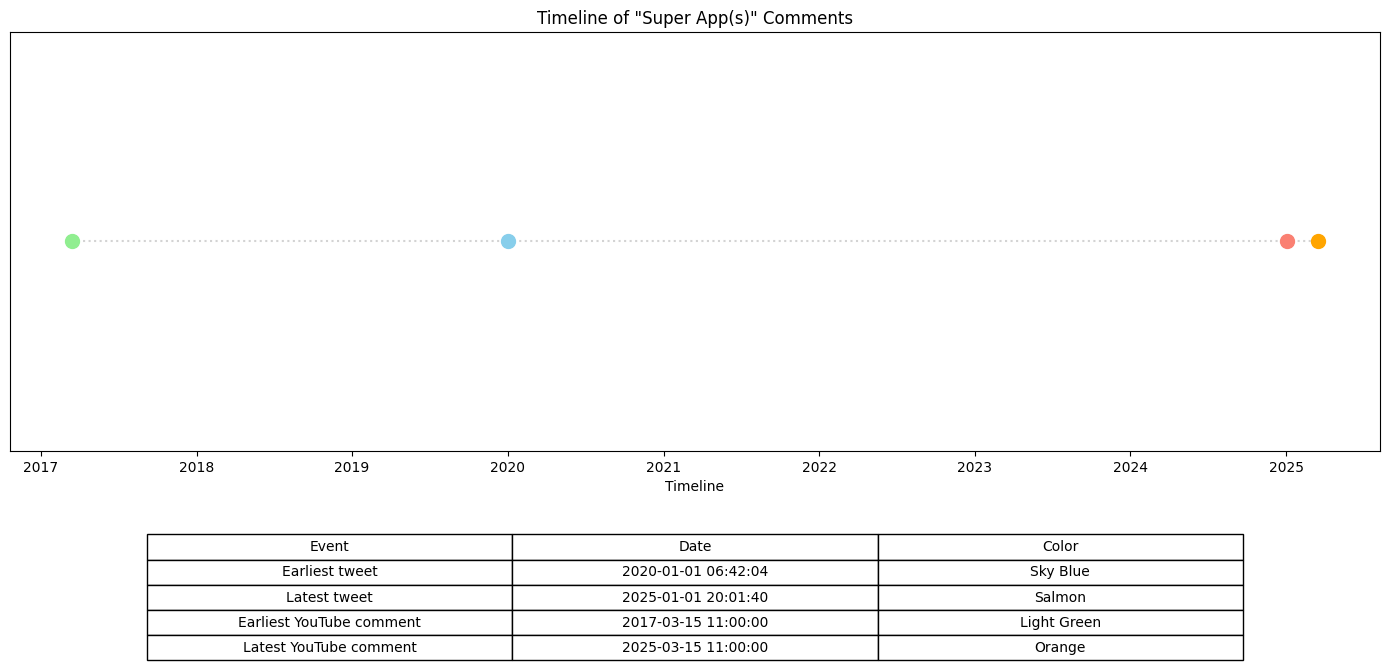

Exact dates:
Earliest tweet: 2020-01-01 06:42:04+00:00
Latest tweet: 2025-01-01 20:01:40+00:00
Earliest YouTube comment: 2017-03-15 11:00:00+00:00
Latest YouTube comment: 2025-03-15 11:00:00+00:00

Total number of comments: 38089
Number of 'super_apps' tweets: 15569
Number of 'super_apps' YouTube comments: 22520


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Converting UTC_Time to datetime if not already
data['Date_of_comment'] = pd.to_datetime(data['Date_of_comment'], utc=True)

# Sorting the merged dataframe by UTC_Time
data = data.sort_values('Date_of_comment')

# Finding the earliest and latest dates for the entire dataset
earliest_comment = data['Date_of_comment'].min()
latest_comment = data['Date_of_comment'].max()

# Finding the earliest and latest dates for Twitter
twitter_data = data[data['source'] == 'super_apps_twitter']
earliest_tweet = twitter_data['Date_of_comment'].min()
latest_tweet = twitter_data['Date_of_comment'].max()

# Finding the earliest and latest dates for YouTube
youtube_data = data[data['source'] == 'super_apps_youtube']
earliest_youtube_comment = youtube_data['Date_of_comment'].min()
latest_youtube_comment = youtube_data['Date_of_comment'].max()

# Creating events list
events = ['Earliest tweet', 'Latest tweet', 'Earliest YouTube comment', 'Latest YouTube comment']
dates = [earliest_tweet, latest_tweet, earliest_youtube_comment, latest_youtube_comment]

colors = ['skyblue', 'salmon', 'lightgreen', 'orange']
color_names = ['Sky Blue', 'Salmon', 'Light Green', 'Orange']

plt.figure(figsize=(14, 6))

# Plotting timeline for all events
plt.hlines(1, min(dates), max(dates), colors='lightgray', linestyles='dotted')

for i, (date, color) in enumerate(zip(dates, colors)):
    plt.scatter(date, 1, color=color, zorder=5, s=100)

plt.yticks([])  # Removing y-axis
plt.xlabel('Timeline')
plt.title('Timeline of "Super App(s)" Comments')

# Formatting dates for the table
formatted_dates = [date.strftime('%Y-%m-%d %H:%M:%S') for date in dates]

table_data = [[events[i], formatted_dates[i], color_names[i]] for i in range(len(events))]
column_labels = ['Event', 'Date', 'Color']
plt.table(cellText=table_data, colLabels=column_labels, loc='bottom', cellLoc='center', bbox=[0.1, -0.5, 0.8, 0.3])

plt.subplots_adjust(bottom=0.45)  # Leaving space for the table
plt.tight_layout()
plt.show()

# Printing exact dates and additional information
print("Exact dates:")
for event, date in zip(events, dates):
    print(f"{event}: {date}")

print(f"\nTotal number of comments: {len(data)}")
print(f"Number of 'super_apps' tweets: {len(twitter_data)}")
print(f"Number of 'super_apps' YouTube comments: {len(youtube_data)}")


## Temporal Analysis

/var/folders/mj/5x7htbw969z723myfhgdp_jr0000gn/T/ipykernel_88442/1394727756.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  'twitter': twitter_data.resample('M').size(),
/var/folders/mj/5x7htbw969z723myfhgdp_jr0000gn/T/ipykernel_88442/1394727756.py:38: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  'youtube': youtube_data.resample('M').size()
/var/folders/mj/5x7htbw969z723myfhgdp_jr0000gn/T/ipykernel_88442/1394727756.py:41: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  'twitter': twitter_data.resample('Y').size().fillna(0),
/var/folders/mj/5x7htbw969z723myfhgdp_jr0000gn/T/ipykernel_88442/1394727756.py:42: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  'youtube': youtube_data.resample('Y').size().fillna(0)


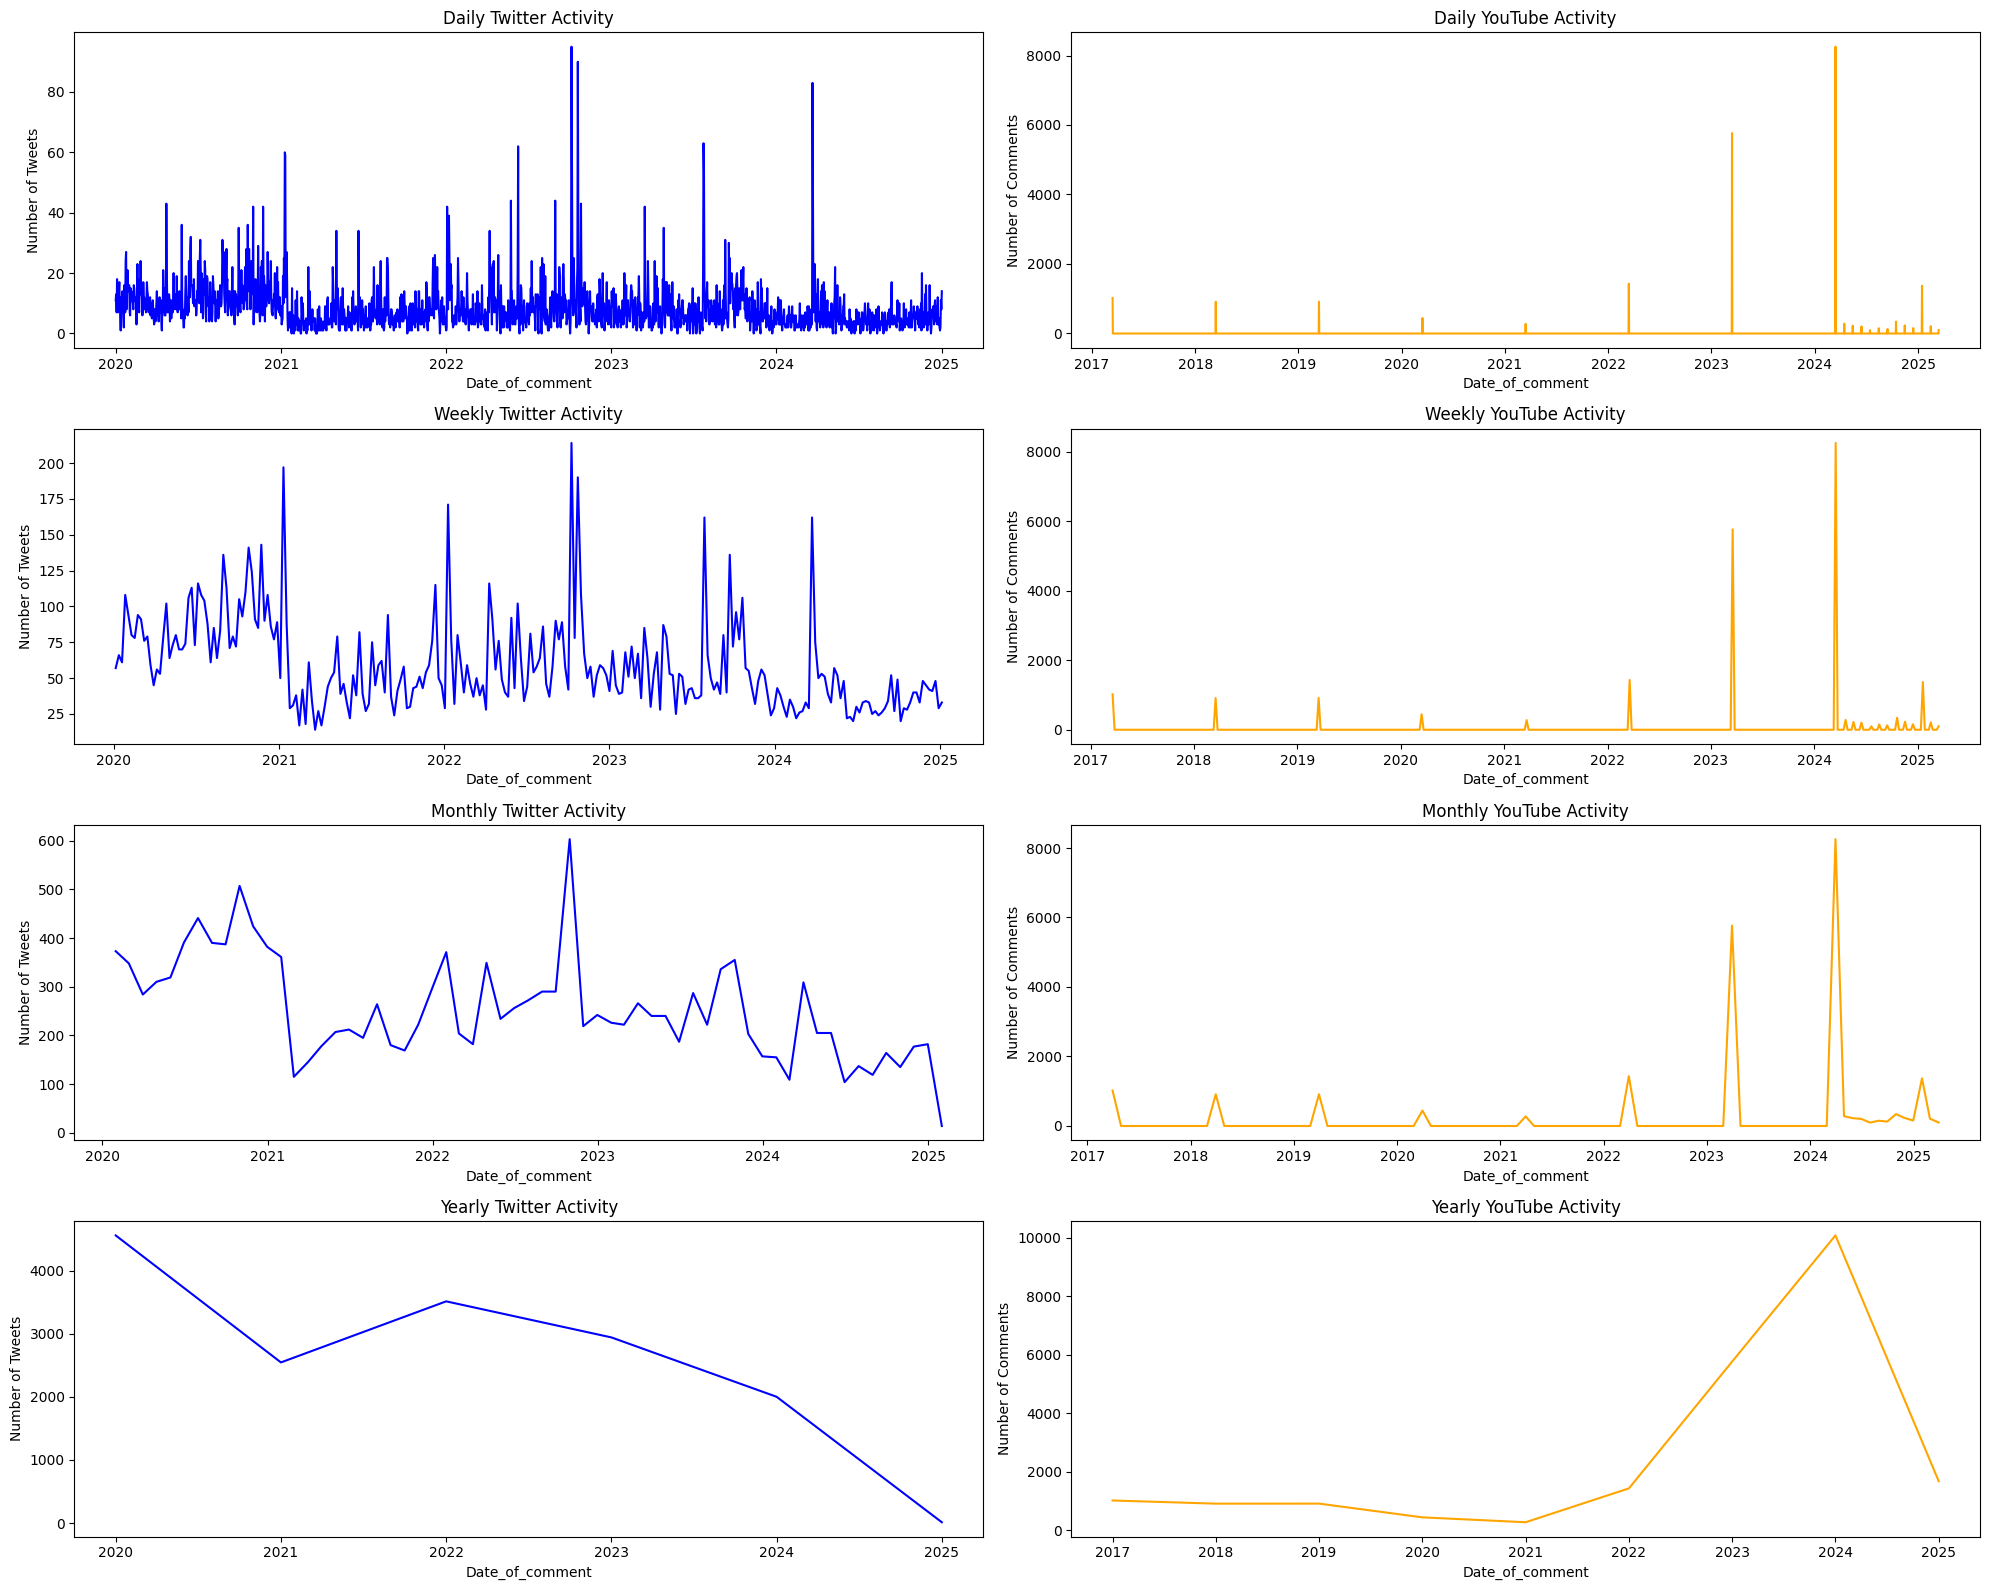

Total number of comments/tweets: 38089
Twitter posts: 15569
YouTube comments: 22520

Date range: from 0 to 38088
Twitter date range: 2020-01-01 06:42:04+00:00 to 2025-01-01 20:01:40+00:00
YouTube date range: 2017-03-15 11:00:00+00:00 to 2025-03-15 11:00:00+00:00

Twitter Max Activity:
Day: 2022-10-05 00:00:00+00:00 (95 Tweets)
Week: 2022-10-09 00:00:00+00:00 (214 Tweets)
Month: 2022-10 (603 Tweets)
Year: 2020 (4556 Tweets)

Youtube Max Activity:
Day: 2024-03-15 00:00:00+00:00 (8254 Comments)
Week: 2024-03-17 00:00:00+00:00 (8254 Comments)
Month: 2024-03 (8254 Comments)
Year: 2024 (10074 Comments)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pytz

# Ensuring 'Date_of_comment' is in datetime format
data['Date_of_comment'] = pd.to_datetime(data['Date_of_comment'])

# Separating data by source
twitter_data = data[data['source'] == 'super_apps_twitter']
youtube_data = data[data['source'] == 'super_apps_youtube']

# Setting indices for both datasets
twitter_data = twitter_data.set_index('Date_of_comment', drop=False)
youtube_data = youtube_data.set_index('Date_of_comment', drop=False)

# Getting current date in UTC
current_date = datetime.datetime.now(pytz.utc)

# Truncation of both datasets
last_date = min(current_date, data['Date_of_comment'].max())
twitter_data = twitter_data[twitter_data.index <= last_date]
youtube_data = youtube_data[youtube_data.index <= last_date]

# Resampling frequencies for both sources
frequency_data = {
    'daily': {
        'twitter': twitter_data.resample('D').size(),
        'youtube': youtube_data.resample('D').size()
    },
    'weekly': {
        'twitter': twitter_data.resample('W').size(),
        'youtube': youtube_data.resample('W').size()
    },
    'monthly': {
        'twitter': twitter_data.resample('M').size(),
        'youtube': youtube_data.resample('M').size()
    },
    'yearly': {
        'twitter': twitter_data.resample('Y').size().fillna(0),
        'youtube': youtube_data.resample('Y').size().fillna(0)
    }
}

# Creating side-by-side plots for each timeframe
plt.figure(figsize=(20, 16))

# Daily frequencies - side by side
plt.subplot(4, 2, 1)
sns.lineplot(x=frequency_data['daily']['twitter'].index, y=frequency_data['daily']['twitter'].values, color='blue')
plt.title('Daily Twitter Activity')
plt.ylabel('Number of Tweets')

plt.subplot(4, 2, 2)
sns.lineplot(x=frequency_data['daily']['youtube'].index, y=frequency_data['daily']['youtube'].values, color='orange')
plt.title('Daily YouTube Activity')
plt.ylabel('Number of Comments')

# Weekly frequencies - side by side
plt.subplot(4, 2, 3)
sns.lineplot(x=frequency_data['weekly']['twitter'].index, y=frequency_data['weekly']['twitter'].values, color='blue')
plt.title('Weekly Twitter Activity')
plt.ylabel('Number of Tweets')

plt.subplot(4, 2, 4)
sns.lineplot(x=frequency_data['weekly']['youtube'].index, y=frequency_data['weekly']['youtube'].values, color='orange')
plt.title('Weekly YouTube Activity')
plt.ylabel('Number of Comments')

# Monthly frequencies - side by side
plt.subplot(4, 2, 5)
sns.lineplot(x=frequency_data['monthly']['twitter'].index, y=frequency_data['monthly']['twitter'].values, color='blue')
plt.title('Monthly Twitter Activity')
plt.ylabel('Number of Tweets')

plt.subplot(4, 2, 6)
sns.lineplot(x=frequency_data['monthly']['youtube'].index, y=frequency_data['monthly']['youtube'].values, color='orange')
plt.title('Monthly YouTube Activity')
plt.ylabel('Number of Comments')

# Yearly frequencies - side by side
plt.subplot(4, 2, 7)
# Converting indexes to year strings for twitter (X)
twitter_yearly = frequency_data['yearly']['twitter']
twitter_yearly.index = twitter_yearly.index.year.astype(str)
sns.lineplot(x=twitter_yearly.index, y=twitter_yearly.values, color='blue')
plt.title('Yearly Twitter Activity')
plt.ylabel('Number of Tweets')

plt.subplot(4, 2, 8)
# Converting indexes to year strings for youtube
youtube_yearly = frequency_data['yearly']['youtube']
youtube_yearly.index = youtube_yearly.index.year.astype(str)
sns.lineplot(x=youtube_yearly.index, y=youtube_yearly.values, color='orange')
plt.title('Yearly YouTube Activity')
plt.ylabel('Number of Comments')

plt.tight_layout()
plt.show()

# Printing statistics
print(f"Total number of comments/tweets: {len(data)}")
print(f"Twitter posts: {len(twitter_data)}")
print(f"YouTube comments: {len(youtube_data)}")
print(f"\nDate range: from {data.index.min()} to {data.index.max()}")
print(f"Twitter date range: {twitter_data.index.min()} to {twitter_data.index.max()}")
print(f"YouTube date range: {youtube_data.index.min()} to {youtube_data.index.max()}")

# Printing max activity statistics by platform
for platform in ['twitter', 'youtube']:
    label = "Tweets" if platform == 'twitter' else "Comments"
    print(f"\n{platform.capitalize()} Max Activity:")
    print(f"Day: {frequency_data['daily'][platform].idxmax()} ({frequency_data['daily'][platform].max()} {label})")
    print(f"Week: {frequency_data['weekly'][platform].idxmax()} ({frequency_data['weekly'][platform].max()} {label})")
    print(f"Month: {frequency_data['monthly'][platform].idxmax().strftime('%Y-%m')} ({frequency_data['monthly'][platform].max()} {label})")
    print(f"Year: {frequency_data['yearly'][platform].idxmax()} ({frequency_data['yearly'][platform].max()} {label})")


## User Analysis

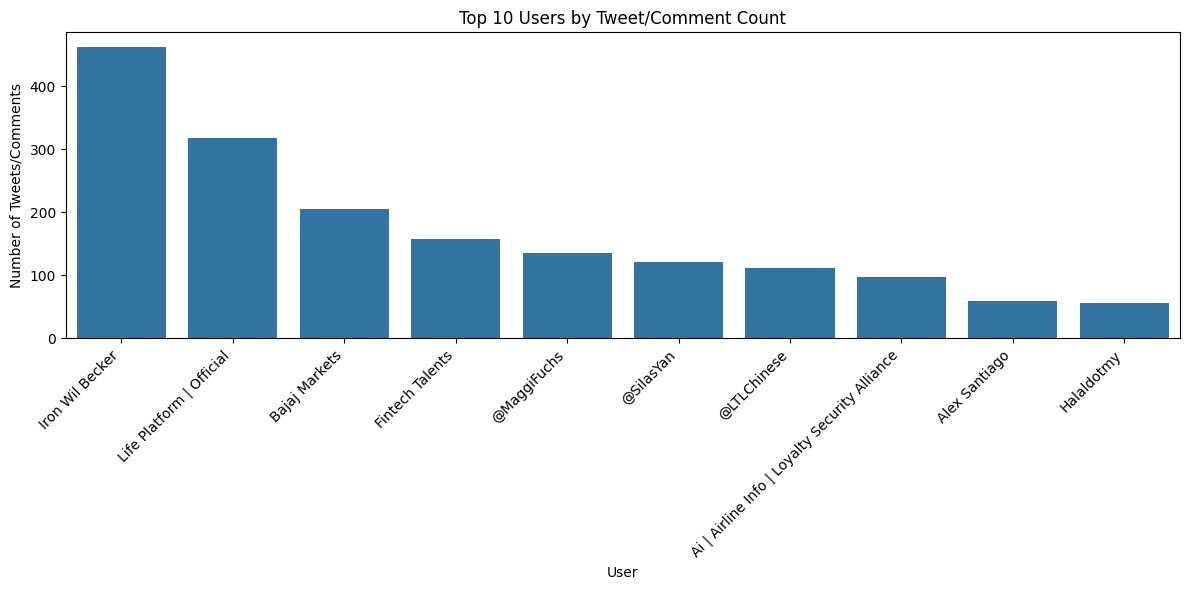

Total number of unique users: 26941
User with most tweets/comments: Iron Wil Becker (462 tweets)

Top 10 users by tweet/comment count:
Author_Name
Iron Wil Becker                                  462
Life Platform | Official                         317
Bajaj Markets                                    205
Fintech Talents                                  157
@MaggiFuchs                                      136
@SilasYan                                        121
@LTLChinese                                      111
Ai | Airline Info | Loyalty Security Alliance     97
Alex Santiago                                     60
Halaldotmy                                        56
Name: count, dtype: int64


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Counting tweets per user
user_tweet_counts = data['Author_Name'].value_counts()

# Top 10 users by tweet count
top_10_users = user_tweet_counts.head(10)

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_users.index, y=top_10_users.values)
plt.title('Top 10 Users by Tweet/Comment Count')
plt.xlabel('User')
plt.ylabel('Number of Tweets/Comments')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Printing statistics
print(f"Total number of unique users: {len(user_tweet_counts)}")
print(f"User with most tweets/comments: {user_tweet_counts.index[0]} ({user_tweet_counts.iloc[0]} tweets)")
print("\nTop 10 users by tweet/comment count:")
print(top_10_users)





In [ ]:
# Settings so that we can see the comments in full size
pd.set_option('display.max_colwidth', None) 
pd.set_option('display.max_rows', None)    


### Checking users and their tweets/comments 

In [ ]:
# Filtering comments by author
life_platform_comments = data[data['Author_Name'] == 'Life Platform | Official']
print(len(life_platform_comments))

# Displaying comments
print(life_platform_comments[['Date_of_comment', 'Comment']])
print(len(data))

317
               Date_of_comment  \
20   2020-01-04 01:23:03+00:00   
27   2020-01-05 19:18:45+00:00   
37   2020-01-07 21:36:37+00:00   
64   2020-01-11 14:38:02+00:00   
77   2020-01-14 22:19:26+00:00   
106  2020-01-18 15:01:02+00:00   
122  2020-01-21 21:30:36+00:00   
142  2020-01-23 22:13:28+00:00   
151  2020-01-24 21:26:17+00:00   
168  2020-01-26 18:42:44+00:00   
199  2020-01-30 22:30:02+00:00   
223  2020-02-01 15:07:37+00:00   
254  2020-02-05 22:00:12+00:00   
263  2020-02-06 19:25:32+00:00   
286  2020-02-08 20:54:13+00:00   
315  2020-02-11 22:30:06+00:00   
339  2020-02-14 00:57:39+00:00   
365  2020-02-18 22:00:19+00:00   
376  2020-02-19 22:04:14+00:00   
384  2020-02-20 22:00:53+00:00   
406  2020-02-23 22:00:29+00:00   
456  2020-02-26 22:00:09+00:00   
470  2020-02-27 02:00:04+00:00   
467  2020-02-27 22:26:16+00:00   
500  2020-03-02 01:06:49+00:00   
514  2020-03-03 22:00:33+00:00   
521  2020-03-04 22:33:56+00:00   
529  2020-03-05 20:00:10+00:00   
544  2020-

In [ ]:
# filtering comments by author
iron_wil_becker_comments = data[data['Author_Name'] == 'Iron Wil Becker']
print(len(iron_wil_becker_comments))

# Displaying comments
print(iron_wil_becker_comments[['Date_of_comment', 'Comment']])
print(len(data))

### Removing all comments/tweets from certain users

In [ ]:
# Filtering out posts from the user "Iron Wil Becker"
data = data[data['Author_Name'] != 'Iron Wil Becker']

# Verifying the deletion
print(f"Remaining posts: {len(data)}")

Remaining posts: 37627


In [ ]:
# Filtering out posts from the user "Life Platform | Official"
data = data[data['Author_Name'] != 'Life Platform | Official']

# Verifying the deletion
print(f"Remaining posts: {len(data)}")

Remaining posts: 37310


### Cleaned version of the User Analysis

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Counting tweets per user
user_tweet_counts = data['Author_Name'].value_counts()

# Top 10 users by tweet count
top_10_users = user_tweet_counts.head(10)

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_users.index, y=top_10_users.values)
plt.title('Top 10 Users by Tweet/Comment Count')
plt.xlabel('User')
plt.ylabel('Number of Tweets/Comments')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Printing statistics
print(f"Total number of unique users: {len(user_tweet_counts)}")
print(f"User with most tweets/comments: {user_tweet_counts.index[0]} ({user_tweet_counts.iloc[0]} tweets)")
print("\nTop 10 users by tweet/comment count:")
print(top_10_users)





## Hashtag Analysis

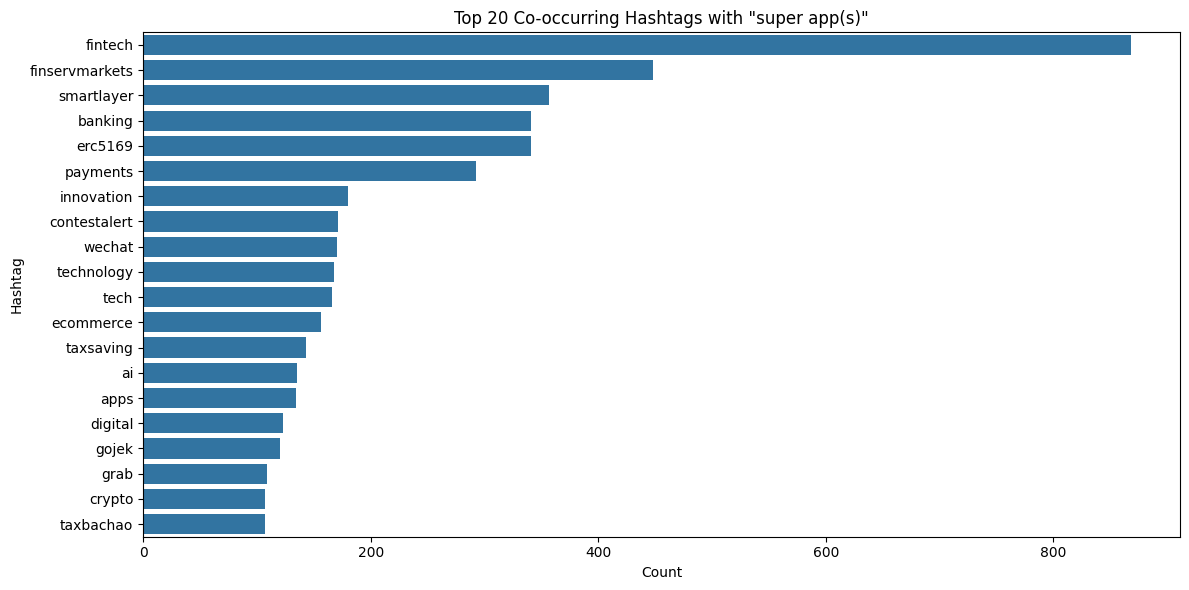

Total number of hashtags used: 22752
Number of unique hashtags: 4564

Top 20 co-occurring hashtags:
           Hashtag  Count
0          fintech    868
1   finservmarkets    448
2       smartlayer    357
3          banking    341
4          erc5169    341
5         payments    293
6       innovation    180
7     contestalert    171
8           wechat    170
9       technology    168
10            tech    166
11       ecommerce    156
12       taxsaving    143
13              ai    135
14            apps    134
15         digital    123
16           gojek    120
17            grab    109
18          crypto    107
19       taxbachao    107

Top 10 co-occurring hashtag pairs:
('finservmarkets', 'superapp'): 435
('erc5169', 'smartlayer'): 332
('fintech', 'superapp'): 147
('contestalert', 'superapp'): 140
('fintech', 'banking'): 135
('fintech', 'payments'): 122
('finservmarkets', 'taxbachao'): 102
('finservmarkets', 'contestalert'): 95
('superapp', 'fintech'): 94
('superapps', 'fintech'): 9

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

def extract_hashtags(text):
    if isinstance(text, str):
        return re.findall(r'#(\w+)', text.lower())
    else:
        return []

# Extracting hashtags from all tweets
all_hashtags = data['Comment'].apply(extract_hashtags).sum()

# Counting hashtag occurrences
hashtag_counts = Counter(all_hashtags)

# Removing 'superapp' and 'superapps' from the count
del hashtag_counts['superapp']
del hashtag_counts['superapps']

# Top 20 hashtags
top_20_hashtags = pd.DataFrame(hashtag_counts.most_common(20), columns=['Hashtag', 'Count'])

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='Hashtag', data=top_20_hashtags)
plt.title('Top 20 Co-occurring Hashtags with "super app(s)"')
plt.xlabel('Count')
plt.ylabel('Hashtag')
plt.tight_layout()
plt.show()

# Printing  statistics
print(f"Total number of hashtags used: {len(all_hashtags)}")
print(f"Number of unique hashtags: {len(hashtag_counts)}")
print("\nTop 20 co-occurring hashtags:")
print(top_20_hashtags)

# Hashtag co-occurrence
def get_hashtag_pairs(hashtags):
    return [(a, b) for idx, a in enumerate(hashtags) for b in hashtags[idx + 1:]]

hashtag_pairs = data['Comment'].apply(lambda x: get_hashtag_pairs(extract_hashtags(x))).sum()
pair_counts = Counter(hashtag_pairs)

print("\nTop 10 co-occurring hashtag pairs:")
for pair, count in pair_counts.most_common(10):
    print(f"{pair}: {count}")


The last four rows in the output represent co-occurring hashtag pairs. These are pairs of hashtags that appear together in the same tweet.

# Sentiment Analysis (Bert)

## Initialization of the model

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# BERT-specific preprocessing
def bert_preprocess(text):
    """Minimal preprocessing optimized for BERT models"""
    text = str(text) if pd.notnull(text) else ""
    text = text.replace('\n', ' ')    # Remove newlines
    text = text.strip()               # Remove leading/trailing whitespace
    return text[:512]                 # Truncate to BERT's max length

# Using Twitter-optimized BERT model
MODEL_NAME = "cardiffnlp/twitter-roberta-base-sentiment"  # for English tweets

# Initializing components with error handling
try:
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
except Exception as e:
    print(f"Error loading model: {e}")
    raise

# Configuring pipeline with batch processing
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    device=0 if torch.cuda.is_available() else -1,  
    truncation=True,
    max_length=512,
    batch_size=16  # Adjusting based on your hardware
)

def analyze_tweets(texts):
    """Process tweets in batches with error handling"""
    results = []
    for batch in tqdm([texts[i:i+16] for i in range(0, len(texts), 16)]):
        try:
            batch_results = sentiment_analyzer(batch)
            results.extend([result['label'] for result in batch_results])
        except Exception as e:
            print(f"Error processing batch: {e}")
            results.extend(['neutral']*len(batch))  # Fallback for failed batches
    return results

# Preprocessing and analyzing
data['clean_text_bert'] = data['Comment'].apply(bert_preprocess)
valid_texts = data[data['clean_text_bert'] != '']['clean_text_bert'].tolist()

print(f"Analyzing {len(valid_texts)} tweets...")
sentiments = analyze_tweets(valid_texts)

# Mapping predictions to standard labels
label_map = {
    'LABEL_0': 'negative',
    'LABEL_1': 'neutral',
    'LABEL_2': 'positive'
}

data['sentiment'] = 'neutral'  # Default value
data.loc[data['clean_text_bert'] != '', 'sentiment'] = [label_map.get(s, 'neutral') for s in sentiments]




/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=88442) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Device set to use cpu


Analyzing 37310 tweets...


100%|██████████| 2332/2332 [10:53<00:00,  3.57it/s]


## Visualization of sentiment based on superapp

In [ ]:
import plotly.graph_objs as go
import pandas as pd
import plotly.io as pio
pio.renderers.default = 'notebook'


# Getting unique categories
categories = sorted(data['category'].unique())

fig = go.Figure()

# Adding traces for each category
for category in categories:
    filtered_data = data[data['category'] == category]
    sentiment_counts = filtered_data['sentiment'].value_counts()

    # Calculating percentage
    total_comments = sentiment_counts.sum()
    sentiment_percentages = (sentiment_counts / total_comments) * 100

    # Adding trace with percentage labels
    fig.add_trace(go.Bar(
        x=sentiment_counts.index,
        y=sentiment_counts.values,
        name=str(category),
        visible=False,
        text=[f'{p:.2f}%' for p in sentiment_percentages],
        textposition='inside',
        hovertext=[f'{count} comments\n({p:.2f}%)' for count, p in zip(sentiment_counts, sentiment_percentages)],
        hoverinfo='text'
    ))

# Adding trace for all categories
all_sentiment_counts = data['sentiment'].value_counts()
total_all_comments = all_sentiment_counts.sum()
all_sentiment_percentages = (all_sentiment_counts / total_all_comments) * 100
fig.add_trace(go.Bar(
    x=all_sentiment_counts.index,
    y=all_sentiment_counts.values,
    name="All Categories",
    visible=True,
    text=[f'{p:.2f}%' for p in all_sentiment_percentages],
    textposition='inside',
    hovertext=[f'{count} comments\n({p:.2f}%)' for count, p in zip(all_sentiment_counts, all_sentiment_percentages)],
    hoverinfo='text'
))

buttons = []

# Adding a button for each category
for i, category in enumerate(categories):
    button = dict(
        label=str(category),
        method="update",
        args=[
            {"visible": [j == i for j in range(len(categories))] + [False]},
            {"title": f"Sentiment Distribution (Category: {category})"}
        ]
    )
    buttons.append(button)

# Adding button to show all categories
buttons.append(
    dict(
        label="All Categories",
        method="update",
        args=[
            {"visible": [False] * len(categories) + [True]},
            {"title": "Sentiment Distribution (All Categories)"}
        ]
    )
)

# Updating layout with buttons
fig.update_layout(
    updatemenus=[dict(
        type="buttons",
        buttons=buttons,
        direction="down",
        showactive=True,
        x=1.1,
        xanchor="right",
        y=1.15,
        yanchor="top"
    )],
    title="Sentiment Distribution (All Categories)",
    xaxis_title="Sentiment",
    yaxis_title="Number of Comments",
    barmode="group"
)

# Show the figure
fig.show()


## Visualization of sentiment based on the platform (YouTube or Twitter)

In [ ]:
import plotly.graph_objs as go
import pandas as pd
pio.renderers.default = 'notebook'


# Getting unique categories
sources = sorted(data['source'].unique())

fig = go.Figure()

# Adding traces for each category
for source in sources:
    filtered_data = data[data['source'] == source]
    sentiment_counts = filtered_data['sentiment'].value_counts()

    # Calculating percentage
    total_comments = sentiment_counts.sum()
    sentiment_percentages = (sentiment_counts / total_comments) * 100

    # Adding trace with percentage labels
    fig.add_trace(go.Bar(
        x=sentiment_counts.index,
        y=sentiment_counts.values,
        name=str(source),
        visible=False,
        text=[f'{p:.2f}%' for p in sentiment_percentages],
        textposition='inside',
        hovertext=[f'{count} comments\n({p:.2f}%)' for count, p in zip(sentiment_counts, sentiment_percentages)],
        hoverinfo='text'
    ))

# Adding a trace for all categories
all_sentiment_counts = data['sentiment'].value_counts()
total_all_comments = all_sentiment_counts.sum()
all_sentiment_percentages = (all_sentiment_counts / total_all_comments) * 100
fig.add_trace(go.Bar(
    x=all_sentiment_counts.index,
    y=all_sentiment_counts.values,
    name="All Categories",
    visible=True,
    text=[f'{p:.2f}%' for p in all_sentiment_percentages],
    textposition='inside',
    hovertext=[f'{count} comments\n({p:.2f}%)' for count, p in zip(all_sentiment_counts, all_sentiment_percentages)],
    hoverinfo='text'
))

buttons = []

# Adding a button for each category
for i, source in enumerate(sources):
    button = dict(
        label=str(source),
        method="update",
        args=[
            {"visible": [j == i for j in range(len(sources))] + [False]},
            {"title": f"Sentiment Distribution (Category: {source})"}
        ]
    )
    buttons.append(button)

# Adding button to show all categories
buttons.append(
    dict(
        label="All Sources",
        method="update",
        args=[
            {"visible": [False] * len(sources) + [True]},
            {"title": "Sentiment Distribution (All Categories)"}
        ]
    )
)

# Updating layout with buttons
fig.update_layout(
    updatemenus=[dict(
        type="buttons",
        buttons=buttons,
        direction="down",
        showactive=True,
        x=1.1,
        xanchor="right",
        y=1.15,
        yanchor="top"
    )],
    title="Sentiment Distribution (All Sources)",
    xaxis_title="Sentiment",
    yaxis_title="Number of Comments",
    barmode="group"
)

# Show the figure
fig.show()


## Sentiment Frequency Visualization


Sentiment Distribution:
sentiment
neutral     40.152774
positive    33.663897
negative    26.183329
Name: proportion, dtype: float64


/var/folders/mj/5x7htbw969z723myfhgdp_jr0000gn/T/ipykernel_88442/647202733.py:29: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



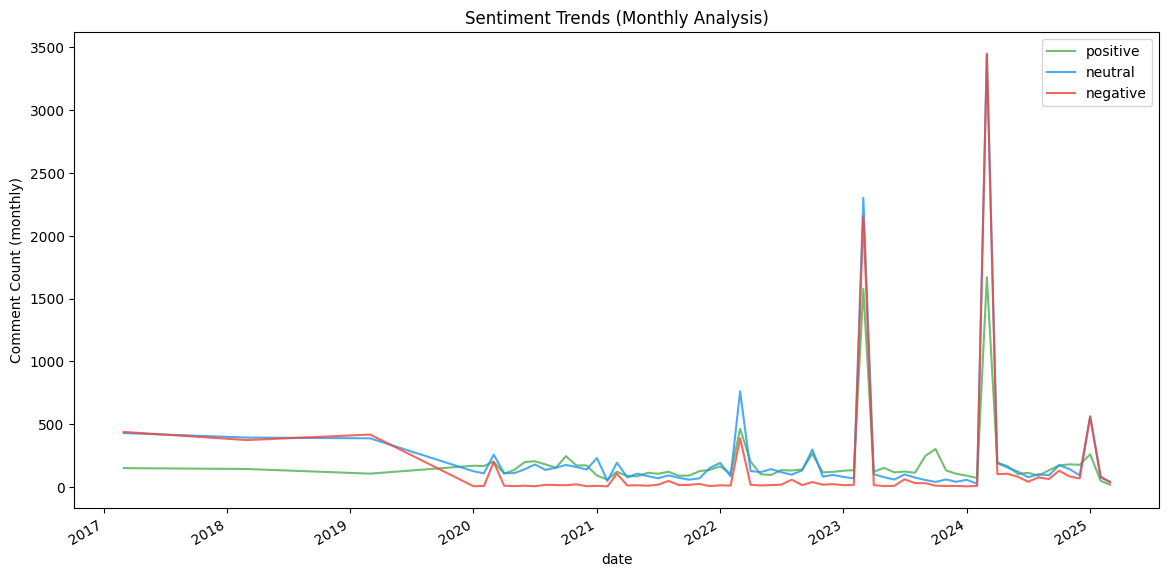

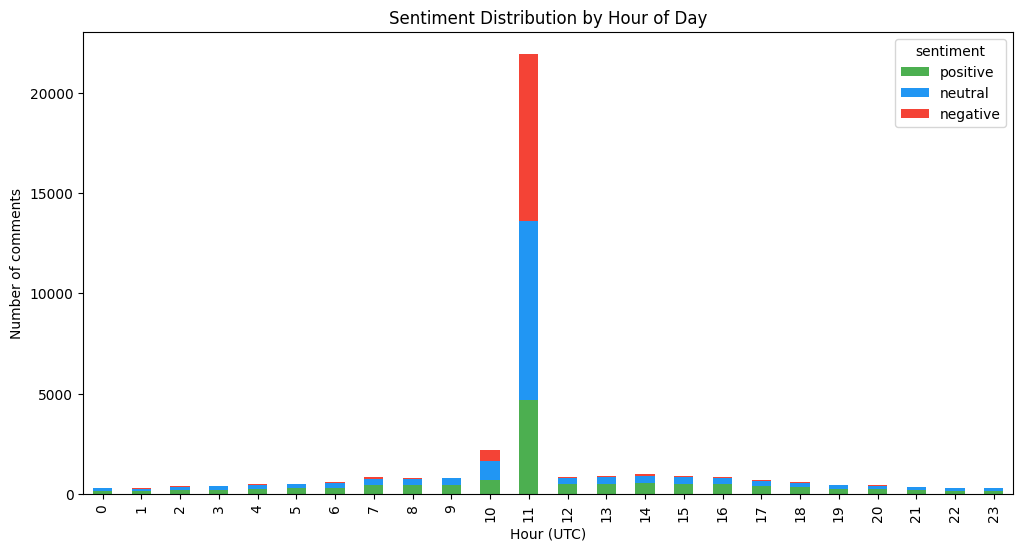

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def sentiment_breakdown(df, granularity='monthly'):
    # Color configuration
    color_map = {
        'positive': '#4CAF50',  # Green
        'neutral': '#2196F3',   # Blue
        'negative': '#F44336'   # Red
    }
    
    # Verify Date_of_comment exists
    if 'Date_of_comment' not in df.columns:
        if 'Date_of_comment' in df.index.names:
            df = df.reset_index()
        else:
            raise ValueError("Date_of_comment column not found in DataFrame")

    breakdown = df['sentiment'].value_counts(normalize=True) * 100
    print(f"\nSentiment Distribution:\n{breakdown}")
    
    # Enhanced temporal analysis
    df['date'] = pd.to_datetime(df['Date_of_comment'])
    
    if granularity == 'weekly':
        df['date'] = df['date'].dt.to_period('W').dt.start_time
    elif granularity == 'monthly':
        df['date'] = df['date'].dt.to_period('M').dt.start_time
    else:  # default to daily
        df['date'] = df['date'].dt.floor('D')
    
    # Sentiment over time
    plt.figure(figsize=(14, 7))
    for sentiment in ['positive', 'neutral', 'negative']:
        subset = df[df['sentiment'] == sentiment]
        counts = subset.groupby('date').size()
        if granularity == 'daily':
            counts.rolling(7).mean().plot(label=sentiment, alpha=0.8, color=color_map[sentiment])
        elif granularity == 'weekly':
            counts.rolling(4).mean().plot(label=sentiment, alpha=0.8, color=color_map[sentiment])
        elif granularity == 'monthly':
            counts.plot(label=sentiment, alpha=0.8, color=color_map[sentiment])  # Direct plot for monthly data
    
    plt.title(f'Sentiment Trends ({granularity.capitalize()} Analysis)')
    plt.ylabel(f'Comment Count ({granularity})')  # Updated label for monthly data
    plt.legend()
    plt.show()

    # Sentiment by hour of day (unchanged)
    df['hour'] = pd.to_datetime(df['Date_of_comment']).dt.hour
    hourly_sentiment = df.groupby(['hour', 'sentiment']).size().unstack()
    
    hourly_sentiment = hourly_sentiment[['positive', 'neutral', 'negative']]
    
    hourly_sentiment.plot(
        kind='bar', 
        stacked=True, 
        figsize=(12,6),
        color=[color_map[col] for col in hourly_sentiment.columns]
    )
    plt.title('Sentiment Distribution by Hour of Day')
    plt.xlabel('Hour (UTC)')
    plt.ylabel('Number of comments')
    plt.show()

# Usage example:
data['Date_of_comment'] = pd.to_datetime(data['Date_of_comment'])
sentiment_breakdown(data.copy(), granularity='monthly')


# Topic Modelling

## Analysis of the most frequent words

### WordClouds - Most Frequent Words – Overall

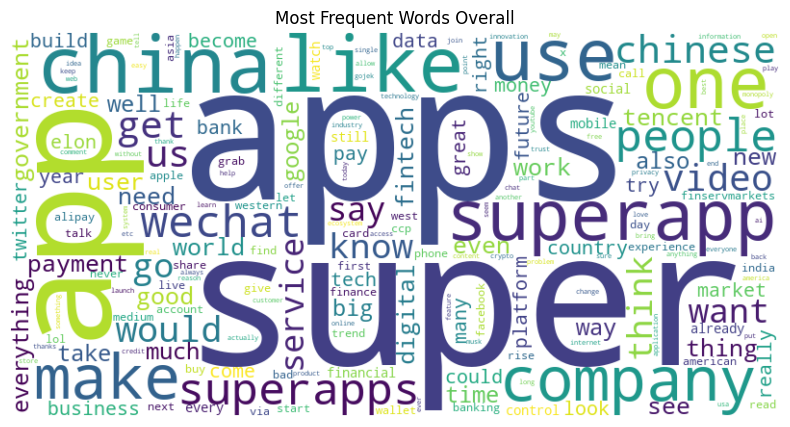

In [ ]:
# Wordcloud for the whole dataset
# Word frequency
word_freq = Counter()
for post in data['tokens']:
    word_freq.update(post)

# Generating the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Displaying the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Most Frequent Words Overall')
plt.axis('off')
plt.show()


### WordClouds - Most Frequent Words – with few exclusions

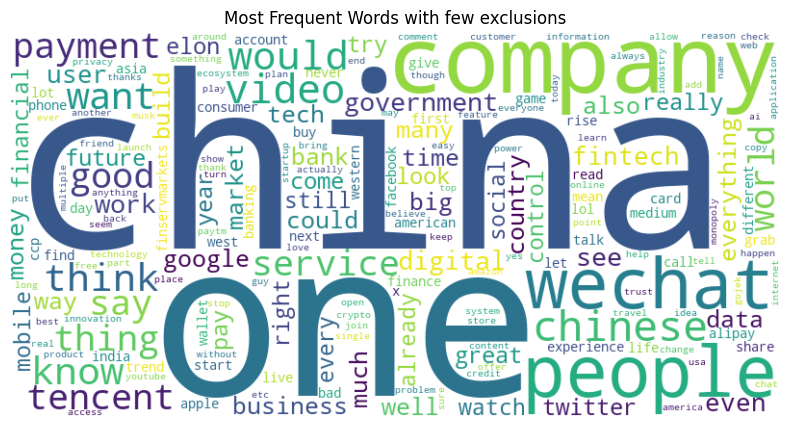

In [ ]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Defining words to exclude
exclude_words = {"super", "app", "superapp", "super app", "super-app", "super apps", "superapps", "apps", "super-apps", "via", "us", 
"get", "make", "use", "like", "new", "need", "go", "create", "become", "take", "platform"}

# Word frequency
word_freq_1 = Counter()
for post in data['tokens']:
    filtered_tokens = [word for word in post if word.lower() not in exclude_words]
    word_freq_1.update(filtered_tokens)

# Generating the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_1)
# Displaying the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Most Frequent Words with few exclusions')
plt.axis('off')
plt.show()


### Table – Top 20 most used words – Overall

In [ ]:
# Top 20 most frequent words
# Sorting word frequencies in descending order and get the top 20
top_20_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:20]

# Generating the order with correct suffixes
def get_ordinal_suffix(n):
    if 10 <= n % 100 <= 20: 
        return f'{n}th'
    else:
        suffixes = {1: 'st', 2: 'nd', 3: 'rd'}
        return f'{n}{suffixes.get(n % 10, "th")}'

# Generating the "Place" row with suffixes
order_with_suffix = [get_ordinal_suffix(i + 1) for i in range(len(top_20_word_freq))]

# Preparing the table data
table_data = [['Place', *order_with_suffix]]  # First row with place labels
table_data.append(['Word'] + [word for word, freq in top_20_word_freq])  # Second row with words
table_data.append(['Frequency'] + [freq for word, freq in top_20_word_freq])  # Third row with frequencies

# Printing the transposed table
print('Top 20 Most Common Words (Overall):')
print(tabulate(table_data, headers='firstrow', tablefmt='grid'))


Top 20 Most Common Words (Overall):
+-----------+-------+-------+-------+-------+-------+-------+-------+----------+---------+--------+-----------+--------+--------+---------+--------+--------+--------+--------+--------+--------+
| Place     | 1st   | 2nd   | 3rd   | 4th   | 5th   | 6th   | 7th   | 8th      | 9th     | 10th   | 11th      | 12th   | 13th   | 14th    | 15th   | 16th   | 17th   | 18th   | 19th   | 20th   |
+===========+=======+=======+=======+=======+=======+=======+=======+==========+=========+========+===========+========+========+=========+========+========+========+========+========+========+
| Word      | apps  | super | app   | china | like  | use   | one   | superapp | company | make   | superapps | people | wechat | chinese | get    | us     | video  | would  | know   | think  |
+-----------+-------+-------+-------+-------+-------+-------+-------+----------+---------+--------+-----------+--------+--------+---------+--------+--------+--------+--------+--------+----

### Table – Top 20 most used words – with few exclusions

In [ ]:
# Top 20 with excluded words
# Words to exclude from the table
exclude_words = {"super", "app", "superapp", "super app", "super-app", "super apps", "superapps", "apps", "super-apps", 
"via", "us", "get", "make", "use", "like", "new", "need", "go", "create", "become", "take", "would", "know", "think", "want", "say", "see", "even"}
# Sorting the original word frequencies by frequency in descending order
sorted_word_freq = sorted(word_freq_1.items(), key=lambda x: x[1], reverse=True)

# Filtering out the words to exclude
filtered_sorted_word_freq = [(word, freq) for word, freq in sorted_word_freq if word not in exclude_words]

# Taking the top 20 after filtering
top_20_filtered_word_freq = filtered_sorted_word_freq[:20]

# Generating the order with correct suffixes for the top 20
order_with_suffix_filtered = [get_ordinal_suffix(i + 1) for i in range(len(top_20_filtered_word_freq))]

# Preparing the table data
filtered_table_data = [['Place', *order_with_suffix_filtered]]  # First row with place labels
filtered_table_data.append(['Word'] + [word for word, freq in top_20_filtered_word_freq])  # Second row with words
filtered_table_data.append(['Frequency'] + [freq for word, freq in top_20_filtered_word_freq])  # Third row with frequencies

# Printing the filtered table
print('Top 20 Most Common Words (Filtered):')
print(tabulate(filtered_table_data, headers='firstrow', tablefmt='grid'))

Top 20 Most Common Words (Filtered):
+-----------+-------+-------+---------+--------+--------+---------+-------+---------+---------+---------+--------+--------+--------+------------+--------+---------+--------+---------+------------+--------+
| Place     | 1st   | 2nd   | 3rd     | 4th    | 5th    | 6th     | 7th   | 8th     | 9th     | 10th    | 11th   | 12th   | 13th   | 14th       | 15th   | 16th    | 17th   | 18th    | 19th       | 20th   |
+===========+=======+=======+=========+========+========+=========+=======+=========+=========+=========+========+========+========+============+========+=========+========+=========+============+========+
| Word      | china | one   | company | people | wechat | chinese | video | service | payment | tencent | good   | world  | thing  | government | work   | digital | user   | fintech | everything | time   |
+-----------+-------+-------+---------+--------+--------+---------+-------+---------+---------+---------+--------+--------+--------+-------

### WordClouds - Most Frequent Words related to Wechat, AliPay and KakaoTalk

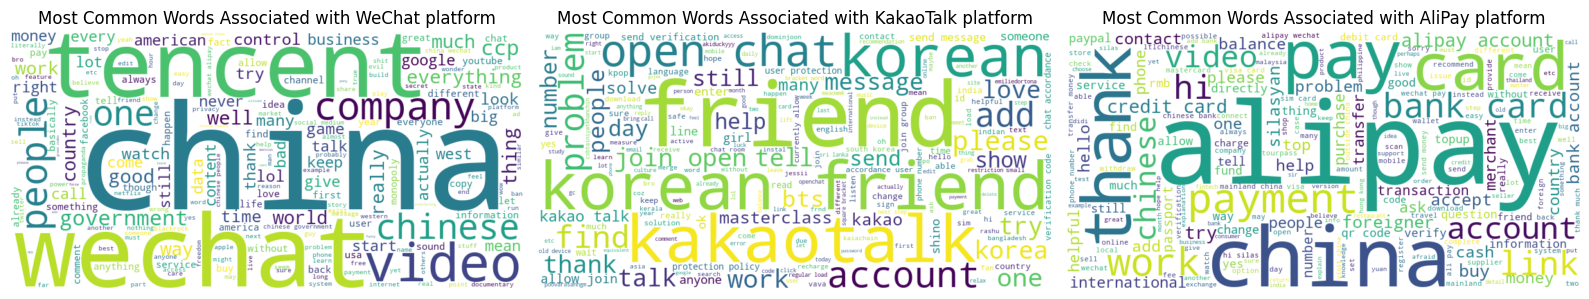

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re

# List of words to exclude (stop words)
stop_words = ["super", "app", "superapp", "super app", "super-app", "super apps", "superapps", "apps", "super-apps", "via", "us", "get", "make", "use", "like", "new", "need", "go", "create", "become", "take", "would", "know", "think", "want", "say", "see", "even"]

# Combining all comments for each party and preprocess text
party_comments = {}
for category, party in zip(["wechat", "kakaotalk", "alipay"], ["WeChat", "KakaoTalk", "AliPay"]):
    comments = ' '.join([' '.join(map(str, tokens)) for tokens in data[data['category'] == category]['tokens']])
    
    # Converting to lowercase and remove punctuation
    comments = comments.lower()
    comments = re.sub(r'[^\w\s]', '', comments)
    
    # Removing stop words
    words = comments.split()
    filtered_words = [word for word in words if word not in stop_words]
    filtered_comments = ' '.join(filtered_words)
    
    party_comments[party] = filtered_comments

# Generating word clouds
wordclouds = {}
for party, comments in party_comments.items():
    wordclouds[party] = WordCloud(width=800, height=400, background_color='white').generate(comments)

# Plotting the word clouds
plt.figure(figsize=(16, 8))
for i, (party, wordcloud) in enumerate(wordclouds.items(), 1):
    plt.subplot(1, len(wordclouds), i)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Most Common Words Associated with {party} platform')
    plt.axis('off')

plt.tight_layout()
plt.show()


### Tables - Most Frequent Words related to Wechat, AliPay and KakaoTalk

In [ ]:
import pandas as pd
from collections import Counter
from tabulate import tabulate

# Function to get ordinal suffix (e.g., 1st, 2nd, 3rd)
def get_ordinal_suffix(n):
    if 11 <= n % 100 <= 13:
        return f"{n}th"
    else:
        suffix = {1: 'st', 2: 'nd', 3: 'rd'}.get(n % 10, 'th')
        return f"{n}{suffix}"

# List of words to exclude (stop words)
stop_words = {"super", "app", "superapp", "super app", "super-app", "super apps", "superapps", "apps", "super-apps", "via", "us", "get", "make", "use", "like", "new", "need", "go", "create", "become", "take", "would", "know", "think", "want", "say", "see", "even"}

# Processing each category and generating tables
for category in ["wechat", "kakaotalk", "alipay"]:
    # Filtering data for the current category
    category_data = data[data['category'] == category]
    
    # Combining all tokens for the category
    all_tokens = [token for tokens_list in category_data['tokens'] for token in tokens_list]
    
    # Filtering out stop words
    filtered_tokens = [token for token in all_tokens if token not in stop_words]
    
    # Calculating word frequencies
    word_freq = Counter(filtered_tokens)
    sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)  # Sorting by frequency
    
    # Taking the top 20 words
    top_20_word_freq = sorted_word_freq[:20]
    
    # Generating the order with correct suffixes for the top 20
    order_with_suffix = [get_ordinal_suffix(i + 1) for i in range(len(top_20_word_freq))]
    
    # Preparing the table data
    table_data = [['Place', *order_with_suffix]]  # First row with place labels
    table_data.append(['Word'] + [word for word, freq in top_20_word_freq])  # Second row with words
    table_data.append(['Frequency'] + [freq for word, freq in top_20_word_freq])  # Third row with frequencies
    
    # Printing the table
    print(f'\nTop 20 Most Common Words for {category.capitalize()}:')
    print(tabulate(table_data, headers='firstrow', tablefmt='grid'))



Top 20 Most Common Words for Wechat:
+-----------+--------+-------+-------+---------+---------+---------+--------+-------+------------+--------+--------+--------+--------+------------+--------+--------+--------+---------+--------+--------+
| Place     | 1st    | 2nd   | 3rd   | 4th     | 5th     | 6th     | 7th    | 8th   | 9th        | 10th   | 11th   | 12th   | 13th   | 14th       | 15th   | 16th   | 17th   | 18th    | 19th   | 20th   |
+===========+========+=======+=======+=========+=========+=========+========+=======+============+========+========+========+========+============+========+========+========+=========+========+========+
| Word      | wechat | china | video | tencent | company | chinese | people | one   | government | good   | world  | thing  | ccp    | everything | much   | work   | well   | country | way    | game   |
+-----------+--------+-------+-------+---------+---------+---------+--------+-------+------------+--------+--------+--------+--------+------------+---

### WordClouds - Most Frequent Words related to Revolut, Grab and Gojek

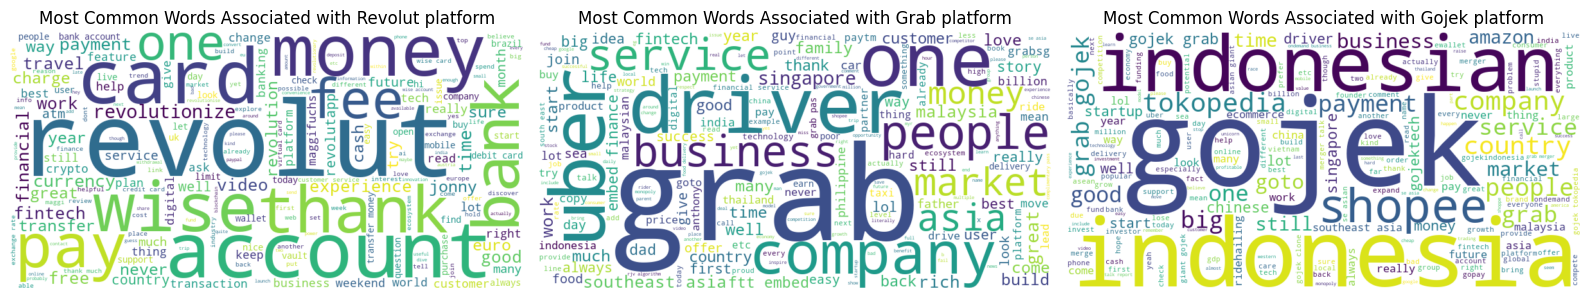

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re

# List of words to exclude (stop words)
stop_words = ["super", "app", "superapp", "super app", "super-app", "super apps", "superapps", "apps", "super-apps", "via", "us", "get", "make", "use", "like", "new", "need", "go", "create", "become", "take", "would", "know", "think", "want", "say", "see", "even"]

# Combining all comments for each party and preprocessing text
party_comments = {}
for category, party in zip(["revolut", "grab", "gojek"], ["Revolut", "Grab", "Gojek"]):
    comments = ' '.join([' '.join(map(str, tokens)) for tokens in data[data['category'] == category]['tokens']])
    
    # Converting to lowercase and removing punctuation
    comments = comments.lower()
    comments = re.sub(r'[^\w\s]', '', comments)
    
    # Removing stop words
    words = comments.split()
    filtered_words = [word for word in words if word not in stop_words]
    filtered_comments = ' '.join(filtered_words)
    
    party_comments[party] = filtered_comments

# Generating word clouds
wordclouds = {}
for party, comments in party_comments.items():
    wordclouds[party] = WordCloud(width=800, height=400, background_color='white').generate(comments)

# Plotting the word clouds
plt.figure(figsize=(16, 8))
for i, (party, wordcloud) in enumerate(wordclouds.items(), 1):
    plt.subplot(1, len(wordclouds), i)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Most Common Words Associated with {party} platform')
    plt.axis('off')

plt.tight_layout()
plt.show()


### Tables - Most Frequent Words related to Revolut, Grab and Gojek

In [ ]:
import pandas as pd
from collections import Counter
from tabulate import tabulate

# Function to get ordinal suffix (e.g., 1st, 2nd, 3rd)
def get_ordinal_suffix(n):
    if 11 <= n % 100 <= 13:
        return f"{n}th"
    else:
        suffix = {1: 'st', 2: 'nd', 3: 'rd'}.get(n % 10, 'th')
        return f"{n}{suffix}"

# List of words to exclude (stop words)
stop_words = {"super", "app", "superapp", "super app", "super-app", "super apps", "superapps", "apps", "super-apps", "via", "us", "get", "make", "use", "like", "new", "need", "go", "create", "become", "take", "would", "know", "think", "want", "say", "see", "even"}

# Processing each category and generating tables
for category in ["grab", "gojek", "revolut"]:
    # Filtering data for the current category
    category_data = data[data['category'] == category]
    
    # Combining all tokens for the category
    all_tokens = [token for tokens_list in category_data['tokens'] for token in tokens_list]
    
    # Filtering out stop words
    filtered_tokens = [token for token in all_tokens if token not in stop_words]
    
    # Calculating word frequencies
    word_freq = Counter(filtered_tokens)
    sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)  # Sort by frequency
    
    # Taking the top 20 words
    top_20_word_freq = sorted_word_freq[:20]
    
    # Generating the order with correct suffixes for the top 20
    order_with_suffix = [get_ordinal_suffix(i + 1) for i in range(len(top_20_word_freq))]
    
    # Preparing the table data
    table_data = [['Place', *order_with_suffix]]  # First row with place labels
    table_data.append(['Word'] + [word for word, freq in top_20_word_freq])  # Second row with words
    table_data.append(['Frequency'] + [freq for word, freq in top_20_word_freq])  # Third row with frequencies
    
    # Printing the table
    print(f'\nTop 20 Most Common Words for {category.capitalize()}:')
    print(tabulate(table_data, headers='firstrow', tablefmt='grid'))



Top 20 Most Common Words for Grab:
+-----------+-------+-------+--------+----------+-------+-------+---------+---------+--------+--------+--------+--------+--------+--------+-----------+--------+-----------+-----------+----------+----------+
| Place     | 1st   | 2nd   | 3rd    | 4th      | 5th   | 6th   | 7th     | 8th     | 9th    | 10th   | 11th   | 12th   | 13th   | 14th   | 15th      | 16th   | 17th      | 18th      | 19th     | 20th     |
+===========+=======+=======+========+==========+=======+=======+=========+=========+========+========+========+========+========+========+===========+========+===========+===========+==========+==========+
| Word      | grab  | uber  | driver | business | asia  | one   | service | company | people | great  | market | money  | work   | rich   | singapore | family | southeast | financial | malaysia | customer |
+-----------+-------+-------+--------+----------+-------+-------+---------+---------+--------+--------+--------+--------+--------+------

### Tables - Most Frequent Words on YouTube and Twitter (X)

In [ ]:
subset_data_youtube = data[data['source'].str.contains('super_apps_youtube', case=False, na=False)]
subset_data_twitter = data[data['source'].str.contains('super_apps_youtube', case=False, na=False)]

In [ ]:
import pandas as pd
from collections import Counter
from tabulate import tabulate

# Function to get ordinal suffix (e.g., 1st, 2nd, 3rd)
def get_ordinal_suffix(n):
    if 11 <= n % 100 <= 13:
        return f"{n}th"
    else:
        suffix = {1: 'st', 2: 'nd', 3: 'rd'}.get(n % 10, 'th')
        return f"{n}{suffix}"

# List of words to exclude (stop words)
stop_words = {"super", "app", "superapp", "super app", "super-app", "super apps", "superapps", "apps", "super-apps", "via", "us", "get", "make", "use", "like", "new", "need", "go", "create", "become", "take", "would", "know", "think", "want", "say", "see", "even"}

# Processing each category and generate tables
for source in ["super_apps_youtube", "super_apps_twitter"]:
    # Filtering data for the current category
    source_data = data[data['source'] == source]
    
    # Combining all tokens for the category
    all_tokens = [token for tokens_list in source_data['tokens'] for token in tokens_list]
    
    # Filtering out stop words
    filtered_tokens = [token for token in all_tokens if token not in stop_words]
    
    # Calculating word frequencies
    word_freq = Counter(filtered_tokens)
    sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)  # Sorting by frequency
    
    # Taking the top 20 words
    top_20_word_freq = sorted_word_freq[:20]
    
    # Generating the order with correct suffixes for the top 20
    order_with_suffix = [get_ordinal_suffix(i + 1) for i in range(len(top_20_word_freq))]
    
    # Preparing the table data
    table_data = [['Place', *order_with_suffix]]  # First row with place labels
    table_data.append(['Word'] + [word for word, freq in top_20_word_freq])  # Second row with words
    table_data.append(['Frequency'] + [freq for word, freq in top_20_word_freq])  # Third row with frequencies
    
    # Printing the table
    print(f'\nTop 20 Most Common Words for {source.capitalize()}:')
    print(tabulate(table_data, headers='firstrow', tablefmt='grid'))



Top 20 Most Common Words for Super_apps_youtube:
+-----------+-------+--------+-------+---------+-------+---------+--------+---------+------------+--------+--------+---------+--------+--------+--------+--------+--------+------------+--------+--------+
| Place     | 1st   | 2nd    | 3rd   | 4th     | 5th   | 6th     | 7th    | 8th     | 9th        | 10th   | 11th   | 12th    | 13th   | 14th   | 15th   | 16th   | 17th   | 18th       | 19th   | 20th   |
+===========+=======+========+=======+=========+=======+=========+========+=========+============+========+========+=========+========+========+========+========+========+============+========+========+
| Word      | china | people | one   | company | video | chinese | wechat | tencent | government | good   | thing  | country | work   | much   | google | world  | well   | everything | money  | time   |
+-----------+-------+--------+-------+---------+-------+---------+--------+---------+------------+--------+--------+---------+--------+---

## Analysis of the most frequent bigrams

### Most frequent bigrams – Overall

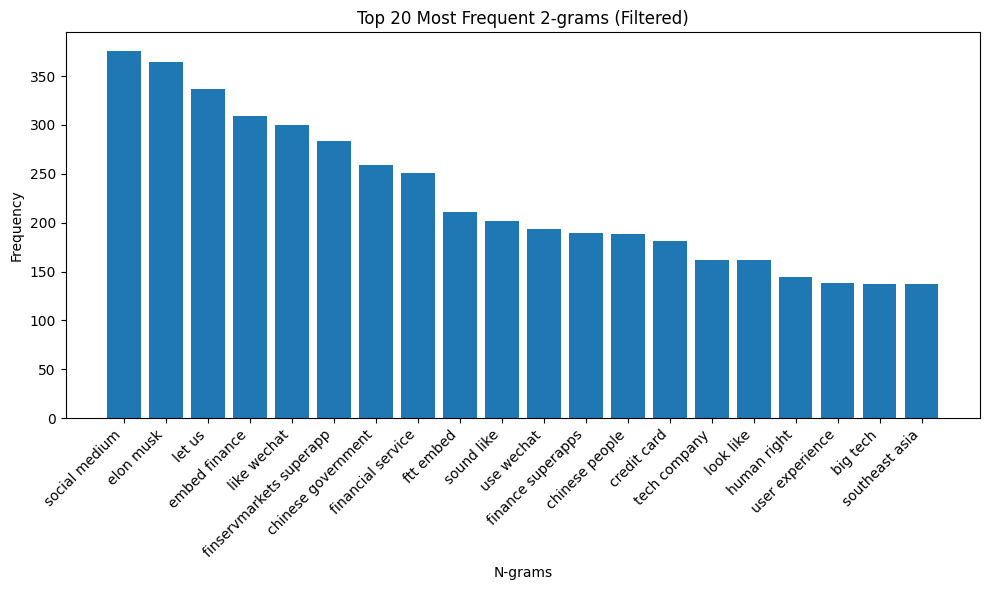

In [ ]:
from nltk import ngrams
from collections import Counter
import matplotlib.pyplot as plt

# Defining words to omit
omit_words = {"super", "app", "apps", "in", "of", "is", "on", "with", "for", "at"} 

# Combining all tokens into a single string
text = ' '.join([' '.join(tokens) for tokens in data['tokens']])

# Filtering out unwanted words
filtered_tokens = [word for word in text.split() if word.lower() not in omit_words]

# Generating bigrams
n = 2
grams = ngrams(filtered_tokens, n)
gram_counts = Counter(grams)

# Getting the most common n-grams
top_n_grams = gram_counts.most_common(20)

# Preparing data for plotting
labels, values = zip(*top_n_grams)
labels = [' '.join(gram) for gram in labels]

# Plotting bigrams
plt.figure(figsize=(10, 6))
plt.bar(labels, values)
plt.xticks(rotation=45, ha='right')
plt.xlabel('N-grams')
plt.ylabel('Frequency')
plt.title(f'Top 20 Most Frequent {n}-grams (Filtered)')
plt.tight_layout()
plt.show()

# Displaying as table using pandas
bigram_table = pd.DataFrame(top_n_grams, columns=['Bigram', 'Frequency'])
bigram_table['Bigram'] = bigram_table['Bigram'].apply(lambda x: ' '.join(x))  # Converting tuple to string
print("\nTop 20 Most Frequent Bigrams:\n")
print(bigram_table.to_string(index=False))


### Most frequent bigrams – with few exclusions

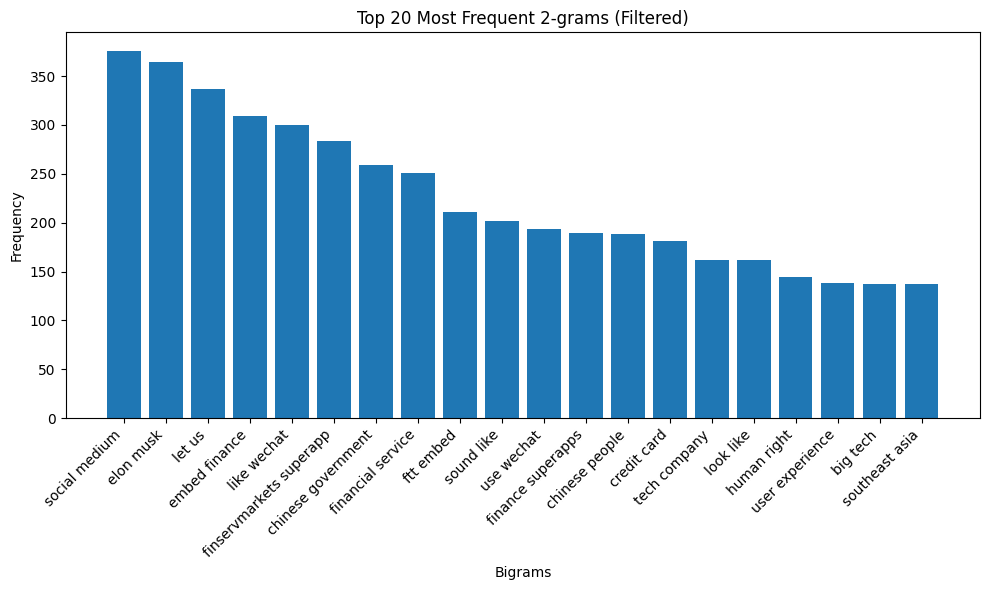


Top 20 Most Frequent Bigrams:

                 Bigram  Frequency
          social medium        376
              elon musk        364
                 let us        337
          embed finance        309
            like wechat        300
finservmarkets superapp        284
     chinese government        259
      financial service        251
              ftt embed        211
             sound like        202
             use wechat        193
      finance superapps        189
         chinese people        188
            credit card        181
           tech company        162
              look like        162
            human right        144
        user experience        138
               big tech        137
         southeast asia        137


In [ ]:
from nltk import ngrams
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd

# Defining words to omit
omit_words = {"super", "app", "apps", "in", "of", "is", "on", "with", "for", "at"}  # Add your custom words here

# Combining all tokens into a single string
text = ' '.join([' '.join(tokens) for tokens in data['tokens']])

# Filtering out unwanted words
filtered_tokens = [word for word in text.split() if word.lower() not in omit_words]

# Generating bigrams
n = 2
grams = ngrams(filtered_tokens, n)
gram_counts = Counter(grams)

# Getting the most common n-grams
top_n_grams = gram_counts.most_common(20)

# Preparing data for plotting
labels, values = zip(*top_n_grams)
labels = [' '.join(gram) for gram in labels]

# Plotting bigrams
plt.figure(figsize=(10, 6))
plt.bar(labels, values)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Bigrams')
plt.ylabel('Frequency')
plt.title(f'Top 20 Most Frequent {n}-grams (Filtered)')
plt.tight_layout()
plt.show()

# Displaying as table using pandas
bigram_table = pd.DataFrame(top_n_grams, columns=['Bigram', 'Frequency'])
bigram_table['Bigram'] = bigram_table['Bigram'].apply(lambda x: ' '.join(x))  # Converting tuple to string
print("\nTop 20 Most Frequent Bigrams:\n")
print(bigram_table.to_string(index=False))


## Topic Modelling using BERTopic

### Topic Modelling – YouTube data

In [ ]:
subset_data_youtube = data[data['source'].str.contains('super_apps_youtube', case=False, na=False)]


In [69]:
print(len(subset_data_youtube))

22520


#### Model initialization – YouTube

In [ ]:
import plotly.io as pio
pio.renderers.default='notebook_connected'

import pandas as pd
import numpy as np
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import MaximalMarginalRelevance
import re
import nltk
from nltk.corpus import stopwords

nltk_stopwords = set(stopwords.words('english'))



extra_stopwords = ['the', 'to', 'and', 'is', 'of', 'in', 'for', 'app', 'apps', 'platform', 'superapp', 'superapps' ,'super','it', 'on', 'this', 'that', 'you', 'your', 'with', 'are', 'we']
all_stop_words = nltk_stopwords.union(set(ENGLISH_STOP_WORDS))

# Data Cleaning Function

def clean_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'#\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = ' '.join([word for word in text.split() if word not in all_stop_words]) 
    return text.lower()


# Loading and Cleaning Data
subset_data_youtube['cleaned_body'] = subset_data_youtube['Comment'].apply(clean_text)


vectorizer_model = CountVectorizer(stop_words=list(all_stop_words))

# Model Configuration

ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

umap_model = UMAP(
    n_neighbors=15, 
    n_components=8,  
    min_dist=0.1,   
    metric='cosine',
    random_state=42
)


hdbscan_model = HDBSCAN(
    min_cluster_size=50, 
    min_samples=15,        
    cluster_selection_epsilon=0.1,
    prediction_data=True,
    metric='euclidean'
)


from bertopic.representation import KeyBERTInspired
representation_model = KeyBERTInspired()

from bertopic.representation import MaximalMarginalRelevance
representation_model = MaximalMarginalRelevance(diversity=0.5)


# BERTopic Model Initialization and Fitting
topic_model_youtube = BERTopic(
    vectorizer_model=vectorizer_model,
    ctfidf_model=ctfidf_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    representation_model=representation_model,
    min_topic_size=150,
    nr_topics="auto",
    low_memory=True,
    calculate_probabilities=True,
    verbose=True
)

# Fitting the model
topics, probs = topic_model_youtube.fit_transform(subset_data_youtube['cleaned_body'].tolist())



# Additional outlier reduction
if -1 in topics:
    print("Reducing outliers...")
    new_topics = topic_model_youtube.reduce_outliers(subset_data_youtube['cleaned_body'].tolist(), topics, strategy="c-tf-idf", threshold=0.05)
    new_topics = topic_model_youtube.reduce_outliers(subset_data_youtube['cleaned_body'].tolist(), new_topics, strategy="distributions", threshold=0.02)
    topic_model_youtube.update_topics(subset_data_youtube['cleaned_body'].tolist(), topics=new_topics)



# Visualizations
topic_model_youtube.visualize_topics(width=1000, height=600).show()
topic_model_youtube.visualize_barchart(top_n_topics=10).show()

topic_info_youtube = topic_model_youtube.get_topic_info()
print(topic_info_youtube)

# Printing representative docs for top 5 topics
for topic in topic_info_youtube['Topic'][:5]:
    if topic != -1:
        print(f"\nTopic {topic} Representative Documents:")
        rep_docs = topic_model_youtube.get_representative_docs(topic)
        for doc in rep_docs[:3]:
            print(doc)
        print("-" * 50)

2025-05-05 01:15:51,540 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/704 [00:00<?, ?it/s]

2025-05-05 01:16:05,384 - BERTopic - Embedding - Completed ✓
2025-05-05 01:16:05,384 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-05 01:16:18,796 - BERTopic - Dimensionality - Completed ✓
2025-05-05 01:16:18,796 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-05 01:16:22,462 - BERTopic - Cluster - Completed ✓
2025-05-05 01:16:22,464 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-05-05 01:16:22,634 - BERTopic - Representation - Completed ✓
2025-05-05 01:16:22,634 - BERTopic - Topic reduction - Reducing number of topics
2025-05-05 01:16:22,646 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-05 01:16:24,211 - BERTopic - Representation - Completed ✓
2025-05-05 01:16:24,218 - BERTopic - Topic reduction - Reduced number of topics from 73 to 48


Reducing outliers...


100%|██████████| 5/5 [00:00<00:00, 45.10it/s]
2025-05-05 01:16:24,580 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


    Topic  Count                                      Name  \
0      -1    367      -1_bleepers_beepers_telegram_thieves   
1       0   3342                 0_china_chinese_app_super   
2       1   1054                  1_youre_comment_lol_dont   
3       2   1526             2_video_thank_channel_content   
4       3   1222                3_alipay_card_account_bank   
5       4    881                    4_twitter_musk_elon_he   
6       5    931                   5_wechat_app_apps_super   
7       6    444    6_indonesia_gojek_indonesian_tokopedia   
8       7    592               7_games_tencent_game_gaming   
9       8    580               8_ccp_china_chinese_tencent   
10      9    567           9_google_apple_android_internet   
11     10    443                   10_elon_trust_hes_idiot   
12     11    400          11_blackrock_black_vanguard_rock   
13     12    418             12_propaganda_news_fake_truth   
14     13    430                    13_snowden_nsa_cia_spy   
15     1

#### Getting detailed information about gotten topics – YouTube

In [ ]:
from bertopic import BERTopic
import pandas as pd

# Getting topic information
topic_info_youtube = topic_model_youtube.get_topic_info()

# Getting more details for each topic
topic_details_youtube = []
for topic in topic_info_youtube['Topic']:
    if topic != -1:  # Excluding the outlier topic
        words = topic_model_youtube.get_topic(topic)
        docs = topic_model_youtube.get_representative_docs(topic)
        topic_details_youtube.append({
            'Topic': topic,
            'Name': topic_info_youtube[topic_info_youtube['Topic'] == topic]['Name'].values[0],
            'Count': topic_info_youtube[topic_info_youtube['Topic'] == topic]['Count'].values[0],
            'Top Words': ', '.join([word for word, _ in words[:10]]),
            'Representative Docs': docs[:3]  # Getting the first 3 representative documents
        })

# Converting to DataFrame for easier viewing
df_topic_details_youtube = pd.DataFrame(topic_details_youtube)
print(df_topic_details_youtube.to_string())


    Topic                                      Name  Count                                                                                         Top Words                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

### Topic Modelling – Twitter (X) data

In [ ]:
subset_data_twitter = data[data['source'].str.contains('super_apps_twitter', case=False, na=False)]


In [73]:
print(len(subset_data_twitter))

14790


#### Model initialization – Twitter (X)

In [ ]:
import plotly.io as pio
pio.renderers.default='notebook_connected'

import pandas as pd
import numpy as np
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import MaximalMarginalRelevance
import re

# Data Cleaning Function
def clean_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'#\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text.lower()

# Loading and Cleaning Data
subset_data_twitter['cleaned_body'] = subset_data_twitter['Comment'].apply(clean_text)

# Custom Stopwords
custom_stopwords = [
    "superapp", "apps", "app", "services", "platform", "digital", "social", "thank", "good", "like", "south", 
    "just", "hey", "oh", "really", "little", "im", "dont", "youre", "hes", "shes", 
    "theyre", "its", "super", "one", "com"
]
all_stop_words = set(ENGLISH_STOP_WORDS)#.union(set(custom_stopwords))

# Model Configuration
vectorizer_model = CountVectorizer(stop_words=list(all_stop_words))
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

umap_model = UMAP(
    n_neighbors=15,
    n_components=10,  # Increased from 8
    min_dist=0.05,     # Increased from 0.0
    metric='cosine',
    random_state=42
)

hdbscan_model = HDBSCAN(
    min_cluster_size=50,  # Decreased from 50
    min_samples=15,        # Decreased from 10
    cluster_selection_epsilon=0.1,  # Increased slightly
    prediction_data=True,
    metric='euclidean'
)

from bertopic.representation import KeyBERTInspired
representation_model = KeyBERTInspired()

# BERTopic Model Initialization and Fitting
topic_model = BERTopic(
    vectorizer_model=vectorizer_model,
    ctfidf_model=ctfidf_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    representation_model=representation_model,
    min_topic_size=100,  # 100
    nr_topics="auto",
    low_memory=True,
    calculate_probabilities=True,
    verbose=True
)

# Fitting the model
topics, probs = topic_model.fit_transform(subset_data_twitter['cleaned_body'].tolist())

# Additional outlier reduction
if -1 in topics:
    print("Reducing outliers...")
    new_topics = topic_model.reduce_outliers(subset_data_twitter['cleaned_body'].tolist(), topics, strategy="c-tf-idf", threshold=0.1)
    new_topics = topic_model.reduce_outliers(subset_data_twitter['cleaned_body'].tolist(), new_topics, strategy="distributions", threshold=0.01)
    topic_model.update_topics(subset_data_twitter['cleaned_body'].tolist(), topics=new_topics)



# Visualizations
topic_model.visualize_topics(width=1000, height=600).show()
topic_model.visualize_barchart(top_n_topics=10).show()

topic_info = topic_model.get_topic_info()
print(topic_info)

# Printing representative docs for top 5 topics
for topic in topic_info['Topic'][:5]:
    if topic != -1:
        print(f"\nTopic {topic} Representative Documents:")
        rep_docs = topic_model.get_representative_docs(topic)
        for doc in rep_docs[:3]:
            print(doc)
        print("-" * 50)

2025-05-05 00:23:33,599 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/463 [00:00<?, ?it/s]

2025-05-05 00:23:46,141 - BERTopic - Embedding - Completed ✓
2025-05-05 00:23:46,141 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-05 00:23:57,115 - BERTopic - Dimensionality - Completed ✓
2025-05-05 00:23:57,116 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-05 00:23:59,014 - BERTopic - Cluster - Completed ✓
2025-05-05 00:23:59,015 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-05-05 00:23:59,185 - BERTopic - Representation - Completed ✓
2025-05-05 00:23:59,186 - BERTopic - Topic reduction - Reducing number of topics
2025-05-05 00:23:59,194 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-05 00:24:01,398 - BERTopic - Representation - Completed ✓
2025-05-05 00:24:01,404 - BERTopic - Topic reduction - Reduced number of topics from 50 to 36


Reducing outliers...


100%|██████████| 7/7 [00:01<00:00,  6.56it/s]
2025-05-05 00:24:02,728 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


    Topic  Count                                    Name  \
0      -1      2            -1_belive_excellence_in_apps   
1       0   2331                     0_super_apps_the_of   
2       1   1653                 1_and_banking_the_super   
3       2    865                      2_india_tata_in_is   
4       3    540                 3_your_insurance_get_on   
5       4    744                      4_africa_in_of_the   
6       5    475                         5_amp_to_the_of   
7       6    519         6_superapps_superapp_coming_the   
8       7    435              7_embedded_finance_ftt_amp   
9       8    649                  8_wechat_like_china_in   
10      9    489              9_ai_metaverse_trends_tech   
11     10    347         10_gojek_grab_airasia_indonesia   
12     11    460           11_elon_twitter_musks_chinese   
13     12    286        12_social_media_twitter_facebook   
14     13    260               13_blockchain_defi_is_and   
15     14    207        14_apple_doj_str

#### Getting detailed information about gotten topics – Twitter (X)

In [ ]:
from bertopic import BERTopic
import pandas as pd

# Getting topic information
topic_info = topic_model.get_topic_info()

# Getting more details for each topic
topic_details = []
for topic in topic_info['Topic']:
    if topic != -1:  # Excluding the outlier topic
        words = topic_model.get_topic(topic)
        docs = topic_model.get_representative_docs(topic)
        topic_details.append({
            'Topic': topic,
            'Name': topic_info[topic_info['Topic'] == topic]['Name'].values[0],
            'Count': topic_info[topic_info['Topic'] == topic]['Count'].values[0],
            'Top Words': ', '.join([word for word, _ in words[:10]]),
            'Representative Docs': docs[:3]  # Getting the first 3 representative documents
        })

# Converting to DataFrame for easier viewing
df_topic_details = pd.DataFrame(topic_details)
print(df_topic_details.to_string())


    Topic                                    Name  Count                                                                                          Top Words                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               Representative Docs
0       0                 